In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

np.set_printoptions(linewidth=np.inf, suppress=True, precision=2)

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel)
from sklearn.gaussian_process import GaussianProcessRegressor  
from sklearn.svm import SVR

import mitosheet

In [3]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)

In [4]:
from solver import deasolver

In [5]:
results = []
df_imp = pd.DataFrame()

In [6]:
df = pd.read_excel("Data/US12I1O.xlsx", index_col = 0)
df

Input 01  Input 02  Input 03  Input 04  Input 05  Input 06  \
DMU 0001    288.81    493.46    202.31    356.18    384.45    653.77   
DMU 0002    349.98    420.00    139.32    312.89    543.04    504.54   
DMU 0003    280.78    452.42    127.85    315.42    559.22    466.35   
DMU 0004    405.33    376.32    237.28    451.43    414.19    318.03   
DMU 0005    348.96    426.79    170.01    292.91    502.76    342.94   
...            ...       ...       ...       ...       ...       ...   
DMU 0996    206.54    333.40    274.01    424.09    465.99    548.04   
DMU 0997    328.82    415.09    121.60    268.46    494.32    454.22   
DMU 0998    310.52    565.44    126.06    320.91    463.01    390.07   
DMU 0999    390.34    255.88    209.15    269.76    576.57    261.14   
DMU 1000    251.60    497.67    256.31    477.68    338.44    716.68   

          Input 07  Input 08  Input 09  Input 10  Input 11  Input 12  \
DMU 0001    129.40    100.28     38.45    306.59     92.41    250.91   
DMU 0002    120.43    177.65     86.96    330.87     79.16    201.81   
DMU 0003    166.57    165.57     81.43    359.75     83.23    246.78   
DMU 0004    187.77    154.65     49.71    316.82     97.74    344.70   
DMU 0005    146.53    165.78     63.80    329.79     76.17    355.61   
...            ...       ...       ...       ...       ...       ...   
DMU 0996    143.02     58.25     49.65    355.16     85.54    238.49   
DMU 0997    150.96    143.44     65.04    374.88     69.81    261.57   
DMU 0998    151.81    202.55    101.67    333.12     87.52    328.13   
DMU 0999    162.39    102.92     66.70    401.16     72.50    318.26   
DMU 1000    158.12    157.51     37.08    273.94     91.51    296.31   

          Output 01  
DMU 0001     250.77  
DMU 0002     372.71  
DMU 0003     293.40  
DMU 0004     462.69  
DMU 0005     374.18  
...             ...  
DMU 0996     279.23  
DMU 0997     344.45  
DMU 0998     320.62  
DMU 0999     380.24  
DMU 1000     408.37  

[1000 rows x 13 columns]

In [7]:
def ml(df=df, sol_filepath="Data/Data12/US12I1O_Sol_0.xlsx", i=None):
    
    df_sol = pd.read_excel(sol_filepath, index_col = 0)[['Efficiency_Scores']]
    df_weights = pd.read_excel(sol_filepath, index_col = 0).iloc[:, 1:]
    
    df_zero = (df_weights==0).sum()
    print("df_zero: \n", df_zero)
    
    total_zeros = (df_weights==0).sum().sum()
    print("Total Zeros: ", total_zeros)
    
    plt.figure(figsize=(18,12))
    sns.heatmap(df_weights.eq(0).transpose(),
            cmap="YlGnBu",
            cbar=False,
            cbar_kws={'label': 'Zero Values'});
    
    X = df
    y = df_sol
    
    std_scaler = StandardScaler()
    mm_scaler = MinMaxScaler()
    
    rf_model = RandomForestRegressor(random_state=42)

    pipe_rf = make_pipeline(std_scaler, rf_model)

    # cross-validate the pipeline
    print("neg_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
    print("neg_root_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
    print("r2:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="r2").mean())
    
        # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    
    # specify parameter values to search
    params = {}
    params['randomforestregressor__n_estimators'] = n_estimators
    params['randomforestregressor__max_features'] = max_features
    params['randomforestregressor__max_depth'] = max_depth
    params['randomforestregressor__min_samples_split'] = min_samples_split
    params['randomforestregressor__min_samples_leaf'] = min_samples_leaf
    params['randomforestregressor__bootstrap'] = bootstrap
    
    grid = RandomizedSearchCV(pipe_rf, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
    grid.fit(X, y.values.ravel())
    
    print("grid.best_score: ", grid.best_score_)
    print("grid.best_params: ", grid.best_params_)
    print("grid.best_estimator: ", grid.best_estimator_)
    print("grid.r2: ", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())
    
    imp_rf = grid.best_estimator_.steps[1][1].feature_importances_
    df_rf = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_rf}).sort_values("Importance", ascending=False)
    input_imp = list(df_rf.loc[df_rf["Feature Name"].str.contains("Input"), "Feature Name"].values)
    results = (i,
                grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_,
               "total_zeros": total_zeros},
              )
    
    fig = px.bar(df_rf, x="Importance", y="Feature Name")

    fig.update_layout(
        autosize=False,
        width=800,
        height=500,
        title_text=f"RandomForestRegressor Feature Importances",
        yaxis={'categoryorder':'total ascending'}
    )

    fig.show()
    
    df_zero.index = [f.split('_')[1] for f in df_zero.index]
    
    df_merged = pd.merge(df_rf, df_zero.reset_index(), left_on='Feature Name', right_on='index')
    df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
    
    df_merged["Iteration"] = i
    
    fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

    fig.update_layout(
        autosize=False,
        width=800,
        height=500,
        title_text=f"RandomForestRegressor Feature Importance - Zero_Count Relationship",
    )

    fig.show()
    
    return pipe_rf, results, y, df_merged

In [8]:
def plotScatter(res_rf, x, y, colorCol, blueCount, redCount):

    fig = px.scatter(res_rf, x=x, y=y, color = colorCol, color_discrete_map= {True:"blue", False: "red"},
                     hover_data=[x, y, colorCol] + [res_rf.index])


    fig.add_traces(
        list(px.line(x = np.linspace(0.3, 1, num=2), y = np.linspace(0.3, 1, num=2)).select_traces())
    )

    fig.update_traces(line_color='lightgreen', line_width=3)

    fig.update_layout(
        autosize=False,
        width=800,
        height=500,
        title_text=f"Efficiency Scores Comparison (Blue: {blueCount}, Red: {redCount})",
    )

    fig.show()

In [9]:
def compareML(pipe_rf, y, X=df, err_thresh = 3):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = pipe_rf.fit(X_train, y_train.values.ravel())
    prediction = model.predict(X_test)
    
    res = pd.DataFrame()
    res["Prediction"] = pd.Series(prediction.ravel())
    res["Actual"] = y_test.values
    res["Diff"] = res.Prediction - res.Actual
    res["Error_Perc"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
    res[f"Error_Perc < {err_thresh}"] = np.abs(res["Error_Perc"]) < err_thresh  
    res = res.round(4)
    print("res: ", res)
    
    blue = res[f"Error_Perc < {err_thresh}"].sum()
    print("blue: ", blue)
    red = len(res[f"Error_Perc < {err_thresh}"]) - (res[f"Error_Perc < {err_thresh}"].sum())
    print("red: ", red)
    
    rho, p = stats.spearmanr(res.Prediction, res.Actual)
    print("rho:", rho.round(4)) 
    print("p-Value", p.round(4)) 
    
    plotScatter(res, x="Actual", y="Prediction", colorCol=f"Error_Perc < {err_thresh}",
               blueCount=blue, redCount=red)

In [10]:
def compareES(df_1_path=None, df_0_path=None, df_basic_path="Data/Data12/US12I1O_Sol_0.xlsx", err_thresh = 10):
    
    df_basic = pd.read_excel(df_basic_path, index_col=0)
    df_1 = pd.read_excel(df_1_path, index_col=0)
    
    res_rf = pd.DataFrame()
    res_rf["Efficiency_Scores_Basic"] = df_basic["Efficiency_Scores"]
    res_rf["Efficiency_Scores_ML"] = df_1["Efficiency_Scores"]

    
    res_rf["Diff_Basic"] = res_rf["Efficiency_Scores_Basic"]  - res_rf["Efficiency_Scores_ML"]
    res_rf["Diff_Basic_Perc"] = (res_rf["Diff_Basic"] / res_rf["Efficiency_Scores_Basic"]) * 100 
    res_rf[f"Diff_Basic_Perc < {err_thresh}"] = np.abs(res_rf["Diff_Basic_Perc"]) < err_thresh
    
    res_rf["Diff_Basic"] = res_rf["Efficiency_Scores_Basic"]  - res_rf["Efficiency_Scores_ML"]
    res_rf["Diff_Basic_Perc"] = (res_rf["Diff_Basic"] / res_rf["Efficiency_Scores_Basic"]) * 100 
    res_rf[f"Diff_Basic_Perc < {err_thresh}"] = np.abs(res_rf["Diff_Basic_Perc"]) < err_thresh
    
    blue = res_rf[f"Diff_Basic_Perc < {err_thresh}"].sum()
    print("blue : ", blue)
    red = len(res_rf[f"Diff_Basic_Perc < {err_thresh}"]) - (res_rf[f"Diff_Basic_Perc < {err_thresh}"].sum())
    print("red : ", red)
    
    res_rf = res_rf.round(4)
    
    plotScatter(res_rf, x="Efficiency_Scores_Basic", y="Efficiency_Scores_ML", colorCol=f"Diff_Basic_Perc < {err_thresh}",
               blueCount=blue, redCount=red)
       
    if df_0_path:
        
        df_0 = pd.read_excel(df_0_path, index_col=0)
        res_rf["Efficiency_Scores_ML_Pr"] = df_0["Efficiency_Scores"]
        
        res_rf["Diff_Previous"] = res_rf["Efficiency_Scores_ML_Pr"]  - res_rf["Efficiency_Scores_ML"]
        res_rf["Diff_Previous_Perc"] = (res_rf["Diff_Previous"] / res_rf["Efficiency_Scores_ML_Pr"]) * 100 
        res_rf[f"Diff_Previous_Perc < {err_thresh}"] = np.abs(res_rf["Diff_Previous_Perc"]) < err_thresh
        
        blue = res_rf[f"Diff_Previous_Perc < {err_thresh}"].sum()
        print("blue : ", blue)
        red = len(res_rf[f"Diff_Previous_Perc < {err_thresh}"]) - (res_rf[f"Diff_Previous_Perc < {err_thresh}"].sum())
        print("red : ", red)
        
        #res_rf = res_rf.round(4)
        
        plotScatter(res_rf, x="Efficiency_Scores_ML_Pr", y="Efficiency_Scores_ML", colorCol=f"Diff_Previous_Perc < {err_thresh}",
               blueCount=blue, redCount=red)


### i=0

In [11]:
i=0

In [12]:
#deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_" + str(i))

df_zero: 
 Weight_Input 01     330
Weight_Input 02     801
Weight_Input 03     249
Weight_Input 04     717
Weight_Input 05     681
Weight_Input 06     396
Weight_Input 07     673
Weight_Input 08     428
Weight_Input 09     599
Weight_Input 10     830
Weight_Input 11     742
Weight_Input 12     757
Weight_Output 01      0
dtype: int64
Total Zeros:  7203
neg_mean_squared_error: -0.0024182156632764663
neg_root_mean_squared_error: -0.049008288162723665
r2: 0.847308437901904
grid.best_score:  -0.049480411923112165
grid.best_params:  {'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 100, 'randomforestregressor__bootstrap': True}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=2,
      

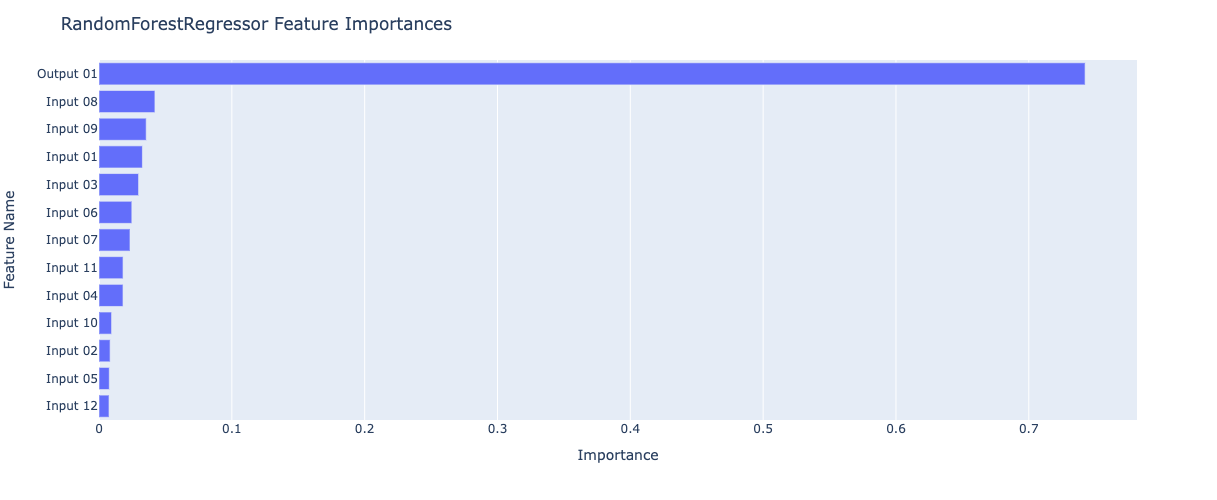

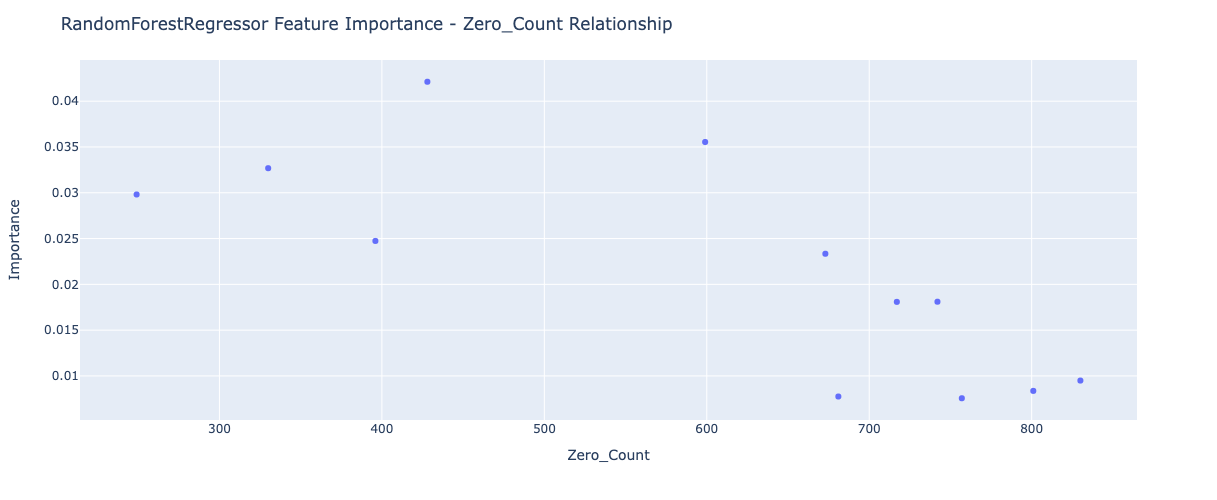

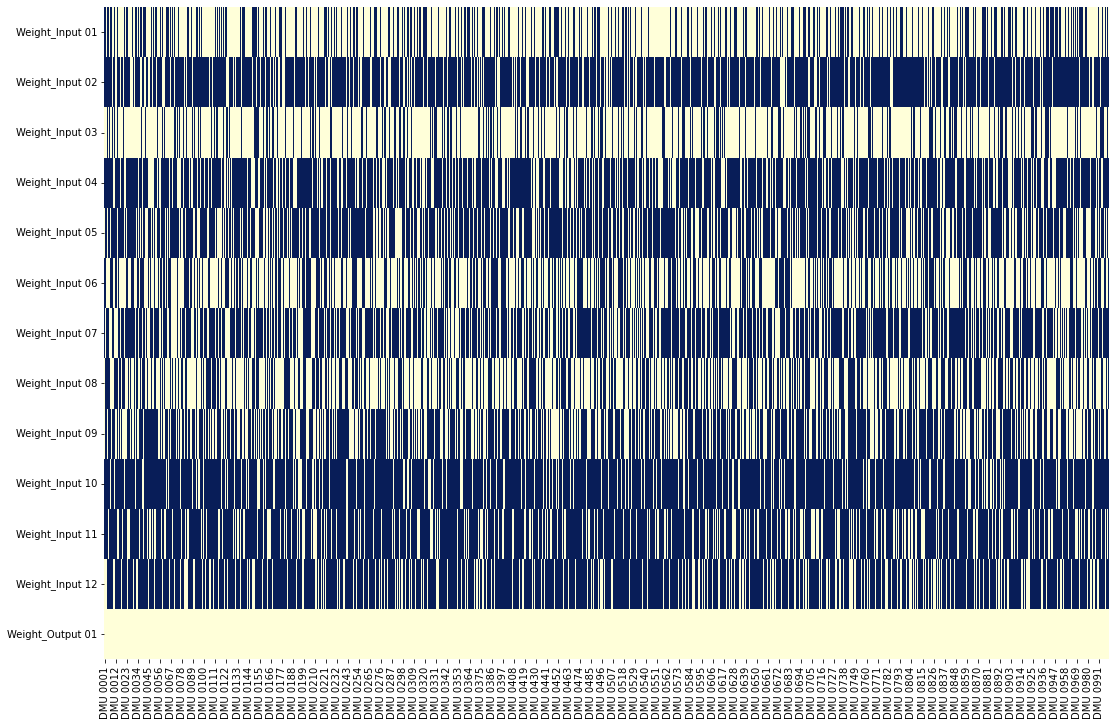

In [13]:
pipe_rf, r, y, df_merged = ml(i=i)
results.append(r)

In [14]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.742394  Output 01           0          0
1      Input 08    0.042123   Input 08         428          0
2      Input 09    0.035544   Input 09         599          0
3      Input 01    0.032683   Input 01         330          0
4      Input 03    0.029812   Input 03         249          0
5      Input 06    0.024740   Input 06         396          0
6      Input 07    0.023341   Input 07         673          0
7      Input 11    0.018104   Input 11         742          0
8      Input 04    0.018087   Input 04         717          0
9      Input 10    0.009492   Input 10         830          0
10     Input 02    0.008366   Input 02         801          0
11     Input 05    0.007752   Input 05         681          0
12     Input 12    0.007562   Input 12         757          0

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7105  0.7514 -0.0409     -5.4444           False
1        0.8273  0.8656 -0.0384     -4.4310           False
2        0.9501  1.0000 -0.0499     -4.9929           False
3        0.9124  0.8711  0.0413      4.7458           False
4        0.7688  0.7903 -0.0215     -2.7235            True
..          ...     ...     ...         ...             ...
195      0.7234  0.7837 -0.0602     -7.6869           False
196      0.8935  0.8507  0.0428      5.0283           False
197      0.8846  0.8364  0.0482      5.7581           False
198      0.9411  1.0000 -0.0589     -5.8918           False
199      0.8166  0.8264 -0.0098     -1.1864            True

[200 rows x 5 columns]
blue:  80
red:  120
rho: 0.908
p-Value 0.0


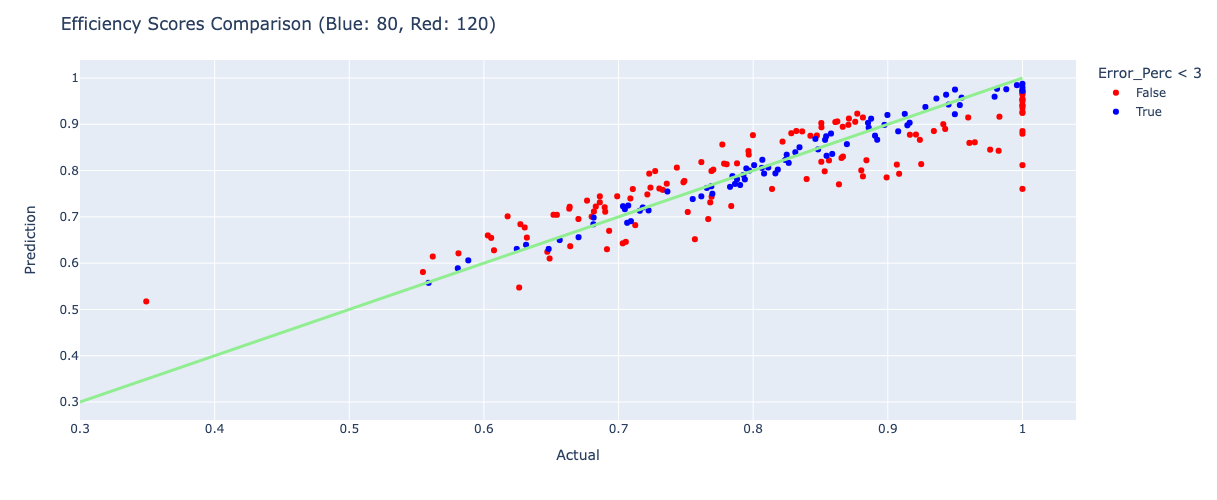

In [15]:
compareML(pipe_rf, y)

In [16]:
results

[(0,
  'randomforestregressor',
  ['Input 08',
   'Input 09',
   'Input 01',
   'Input 03',
   'Input 06',
   'Input 07',
   'Input 11',
   'Input 04',
   'Input 10',
   'Input 02',
   'Input 05',
   'Input 12'],
  {'r2': 0.8447922999521216,
   'neg_root_mean_squared_error': -0.049480411923112165,
   'total_zeros': 7203})]

### i = 1

In [17]:
i +=1
i

1

In [18]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

Restricted license - for non-production use only - expires 2023-10-25


Restricted license - for non-production use only - expires 2023-10-25


20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01       1
Weight_Input 02     798
Weight_Input 03       9
Weight_Input 04     453
Weight_Input 05     851
Weight_Input 06      95
Weight_Input 07     255
Weight_Input 08       0
Weight_Input 09       1
Weight_Input 10     651
Weight_Input 11     287
Weight_Input 12     878
Weight_Output 01      0
dtype: int64
Total Zeros:  4279
neg_mean_squared_error: -0.0015237100998167171
neg_root_mean_squared_error: -0.038889305346098774
r2: 0.8777897340192371
grid.best_score:  -0.0389974404265591
grid.best_params:  {'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 100, 'randomforestregressor__bootstrap': True}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=2,
       

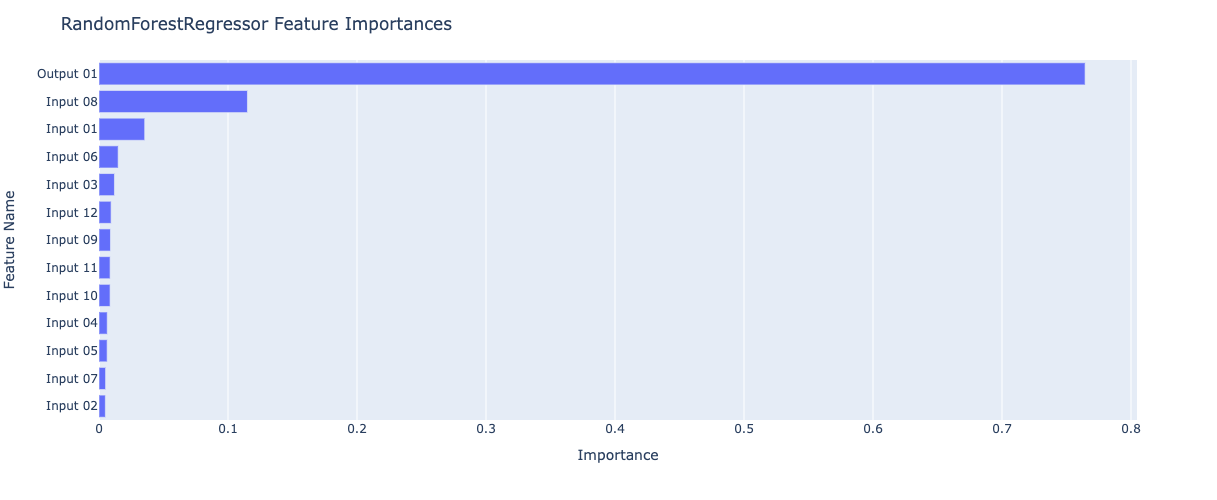

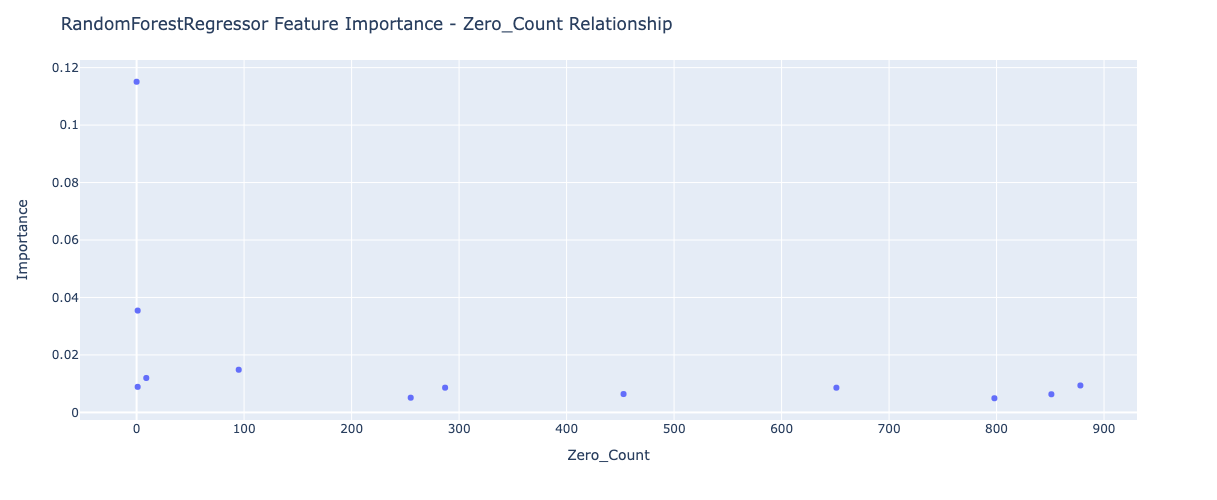

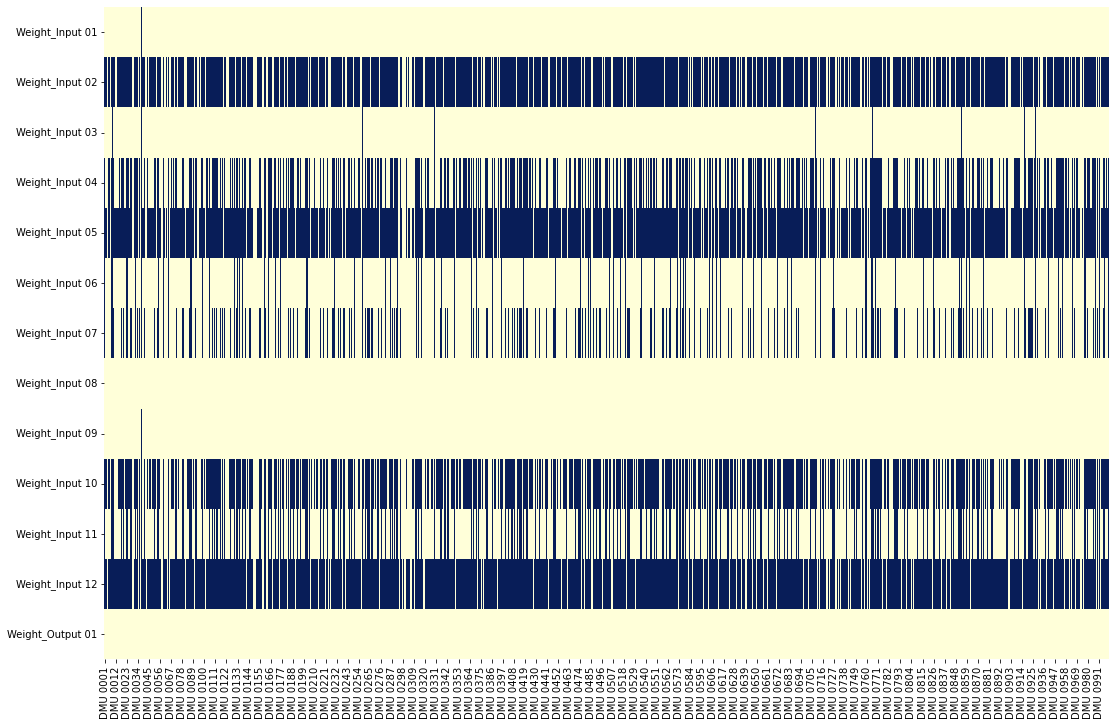

In [19]:
pipe_rf, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_randomforestregressor_Sol_1.xlsx", i=i)
results.append(r)

In [20]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.742394  Output 01           0          0
1      Input 08    0.042123   Input 08         428          0
2      Input 09    0.035544   Input 09         599          0
3      Input 01    0.032683   Input 01         330          0
4      Input 03    0.029812   Input 03         249          0
5      Input 06    0.024740   Input 06         396          0
6      Input 07    0.023341   Input 07         673          0
7      Input 11    0.018104   Input 11         742          0
8      Input 04    0.018087   Input 04         717          0
9      Input 10    0.009492   Input 10         830          0
10     Input 02    0.008366   Input 02         801          0
11     Input 05    0.007752   Input 05         681          0
12     Input 12    0.007562   Input 12         757          0
13    Output 01    0.764417  Output 01           0          1
14     Input 08    0.115076   Input 08           0          1
15     Input 01    0.035439   Input 01           1          1
16     Input 06    0.014850   Input 06          95          1
17     Input 03    0.011979   Input 03           9          1
18     Input 12    0.009376   Input 12         878          1
19     Input 09    0.008895   Input 09           1          1
20     Input 11    0.008606   Input 11         287          1
21     Input 10    0.008599   Input 10         651          1
22     Input 04    0.006395   Input 04         453          1
23     Input 05    0.006317   Input 05         851          1
24     Input 07    0.005122   Input 07         255          1
25     Input 02    0.004928   Input 02         798          1

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6427  0.6293  0.0133      2.1177            True
1        0.6960  0.6714  0.0246      3.6642           False
2        0.8267  0.7978  0.0289      3.6207           False
3        0.8696  0.8373  0.0323      3.8621           False
4        0.7301  0.7741 -0.0439     -5.6774           False
..          ...     ...     ...         ...             ...
195      0.6775  0.6936 -0.0161     -2.3228            True
196      0.8424  0.7984  0.0440      5.5144           False
197      0.7807  0.7915 -0.0108     -1.3645            True
198      0.7981  0.9269 -0.1288    -13.8931           False
199      0.7922  0.8077 -0.0154     -1.9109            True

[200 rows x 5 columns]
blue:  82
red:  118
rho: 0.9382
p-Value 0.0


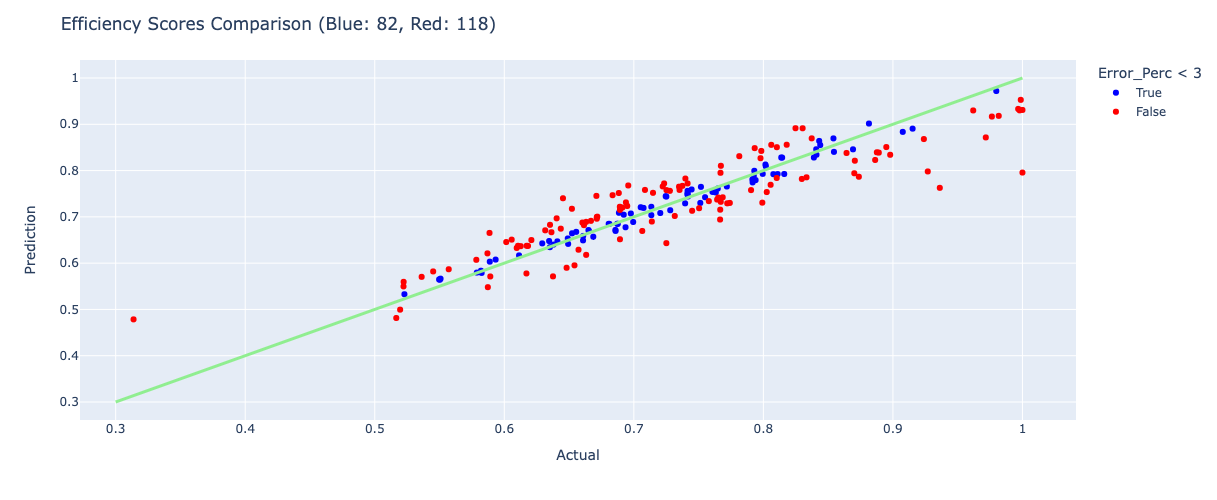

In [21]:
compareML(pipe_rf, y)

blue :  625
red :  375


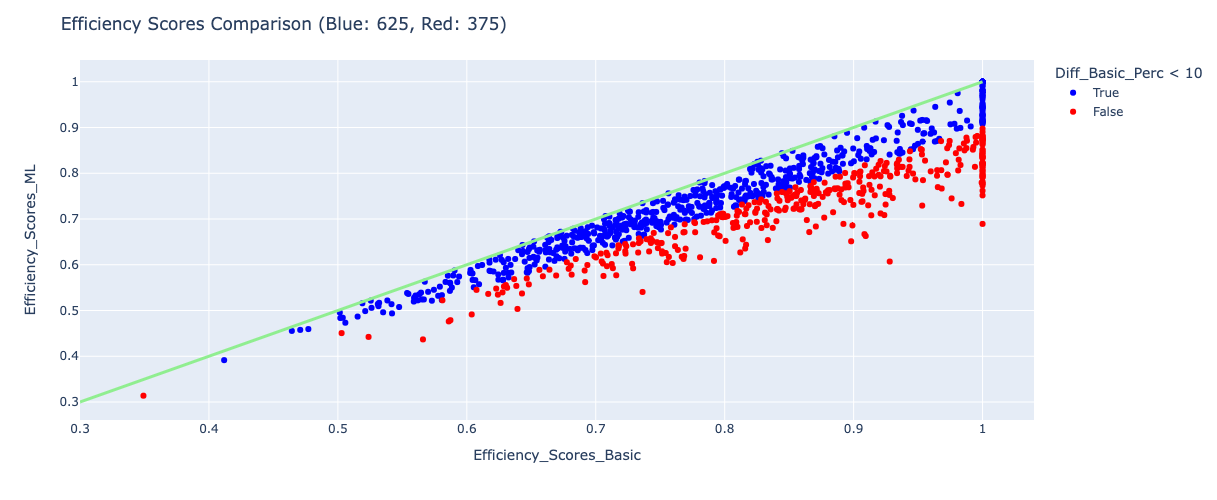

In [22]:
compareES(df_1_path="Data/Data12/US12I1O_randomforestregressor_Sol_1.xlsx")

### i = 2

In [23]:
i +=1
i

2

In [24]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01       1
Weight_Input 02     923
Weight_Input 03      21
Weight_Input 04     330
Weight_Input 05     454
Weight_Input 06       4
Weight_Input 07     546
Weight_Input 08       0
Weight_Input 09     177
Weight_Input 10     282
Weight_Input 11     198
Weight_Input 12      72
Weight_Output 01      0
dtype: int64
Total Zeros:  3008
neg_mean_squared_error: -0.0013554659113651077
neg_root_mean_squared_error: -0.036616440928019925
r2: 0.8909520402231352
grid.best_score:  -0.03648539188521682
grid.best_params:  {'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 100, 'randomforestregressor__bootstrap': True}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=2,
      

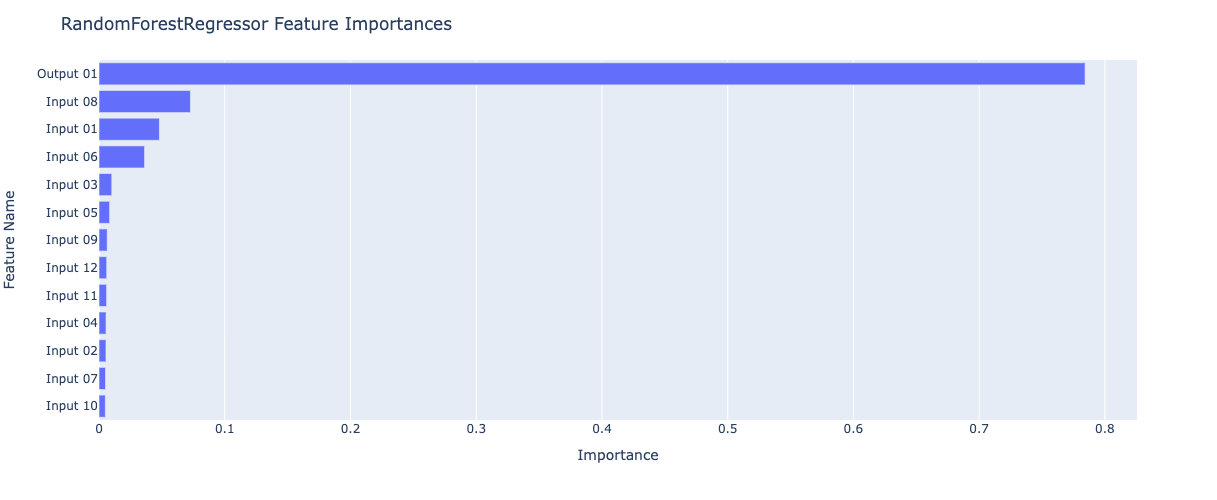

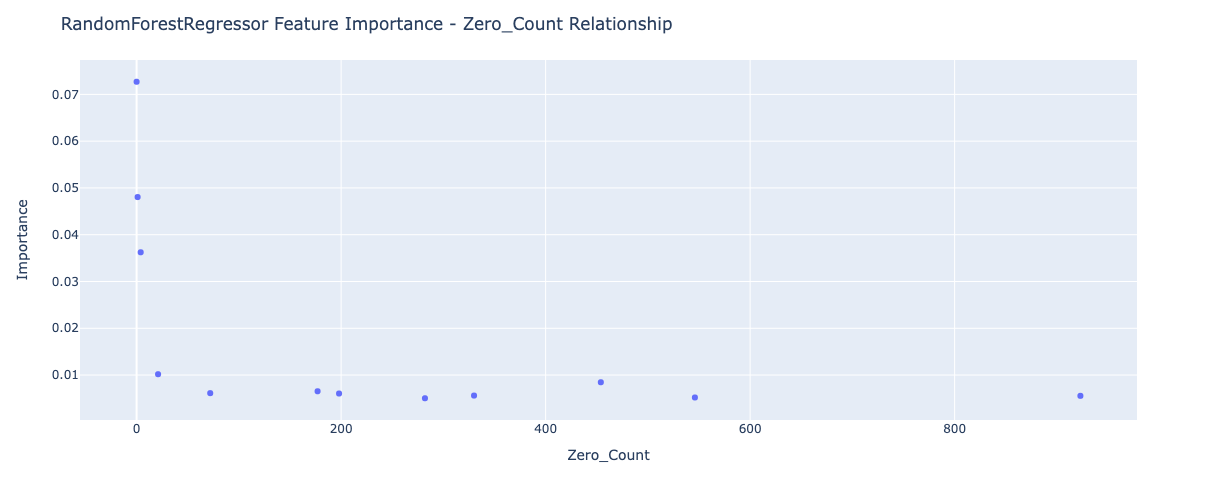

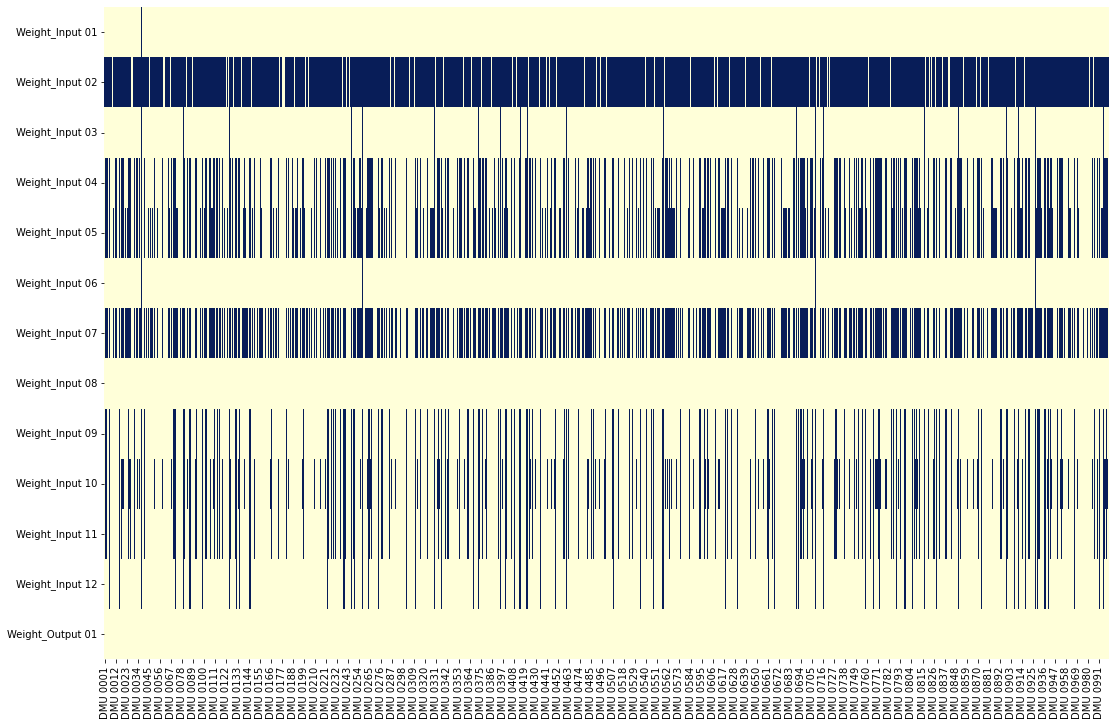

In [25]:
pipe_rf, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_randomforestregressor_Sol_2.xlsx", i=i)
results.append(r)

In [26]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.742394  Output 01           0          0
1      Input 08    0.042123   Input 08         428          0
2      Input 09    0.035544   Input 09         599          0
3      Input 01    0.032683   Input 01         330          0
4      Input 03    0.029812   Input 03         249          0
5      Input 06    0.024740   Input 06         396          0
6      Input 07    0.023341   Input 07         673          0
7      Input 11    0.018104   Input 11         742          0
8      Input 04    0.018087   Input 04         717          0
9      Input 10    0.009492   Input 10         830          0
10     Input 02    0.008366   Input 02         801          0
11     Input 05    0.007752   Input 05         681          0
12     Input 12    0.007562   Input 12         757          0
13    Output 01    0.764417  Output 01           0          1
14     Input 08    0.115076   Input 08           0          1
15     Input 01    0.035439   Input 01           1          1
16     Input 06    0.014850   Input 06          95          1
17     Input 03    0.011979   Input 03           9          1
18     Input 12    0.009376   Input 12         878          1
19     Input 09    0.008895   Input 09           1          1
20     Input 11    0.008606   Input 11         287          1
21     Input 10    0.008599   Input 10         651          1
22     Input 04    0.006395   Input 04         453          1
23     Input 05    0.006317   Input 05         851          1
24     Input 07    0.005122   Input 07         255          1
25     Input 02    0.004928   Input 02         798          1
26    Output 01    0.784254  Output 01           0          2
27     Input 08    0.072699   Input 08           0          2
28     Input 01    0.048047   Input 01           1          2
29     Input 06    0.036244   Input 06           4          2
30     Input 03    0.010178   Input 03          21          2
31     Input 05    0.008460   Input 05         454          2
32     Input 09    0.006532   Input 09         177          2
33     Input 12    0.006130   Input 12          72          2
34     Input 11    0.006051   Input 11         198          2
35     Input 04    0.005611   Input 04         330          2
36     Input 02    0.005555   Input 02         923          2
37     Input 07    0.005201   Input 07         546          2
38     Input 10    0.005039   Input 10         282          2

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6514  0.6199  0.0315      5.0752           False
1        0.6553  0.6425  0.0128      1.9939            True
2        0.8124  0.8143 -0.0019     -0.2304            True
3        0.8559  0.8432  0.0127      1.5111            True
4        0.7089  0.7514 -0.0424     -5.6476           False
..          ...     ...     ...         ...             ...
195      0.7371  0.7370  0.0001      0.0167            True
196      0.8370  0.8236  0.0133      1.6151            True
197      0.7684  0.7835 -0.0150     -1.9198            True
198      0.7681  0.8256 -0.0575     -6.9589           False
199      0.7833  0.8261 -0.0428     -5.1836           False

[200 rows x 5 columns]
blue:  99
red:  101
rho: 0.9479
p-Value 0.0


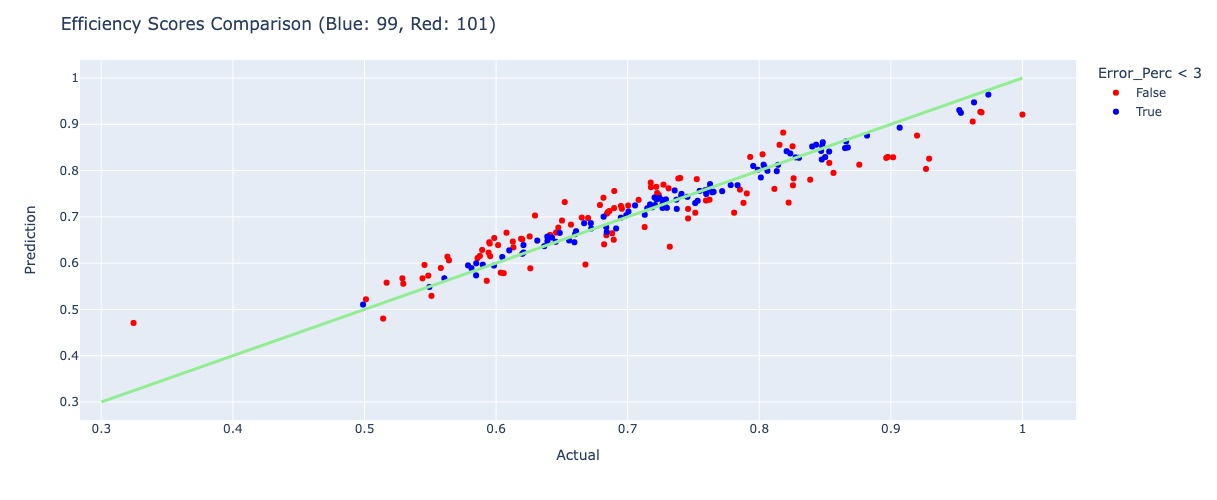

In [27]:
compareML(pipe_rf, y)

blue :  528
red :  472


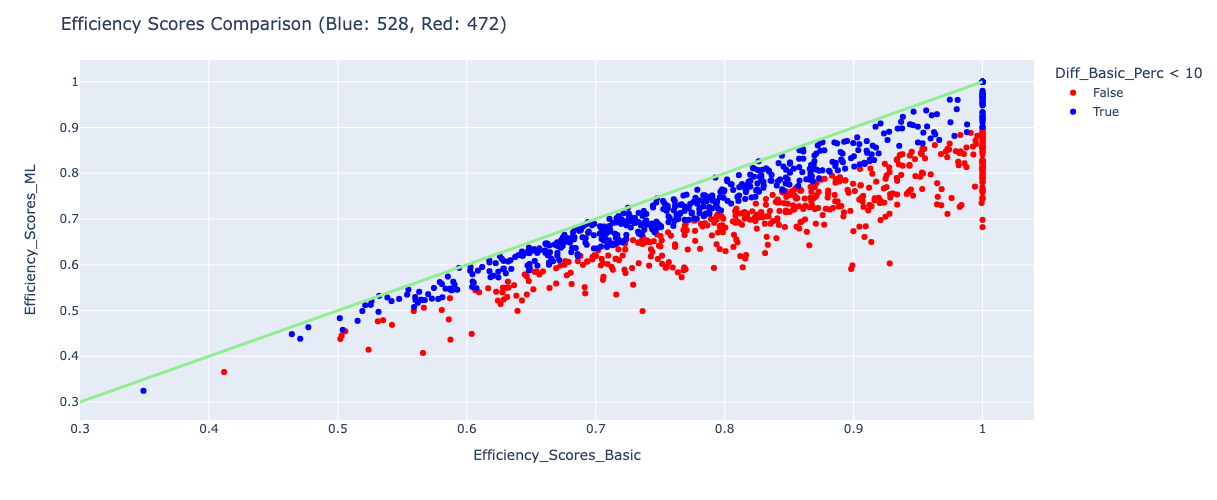

blue :  981
red :  19


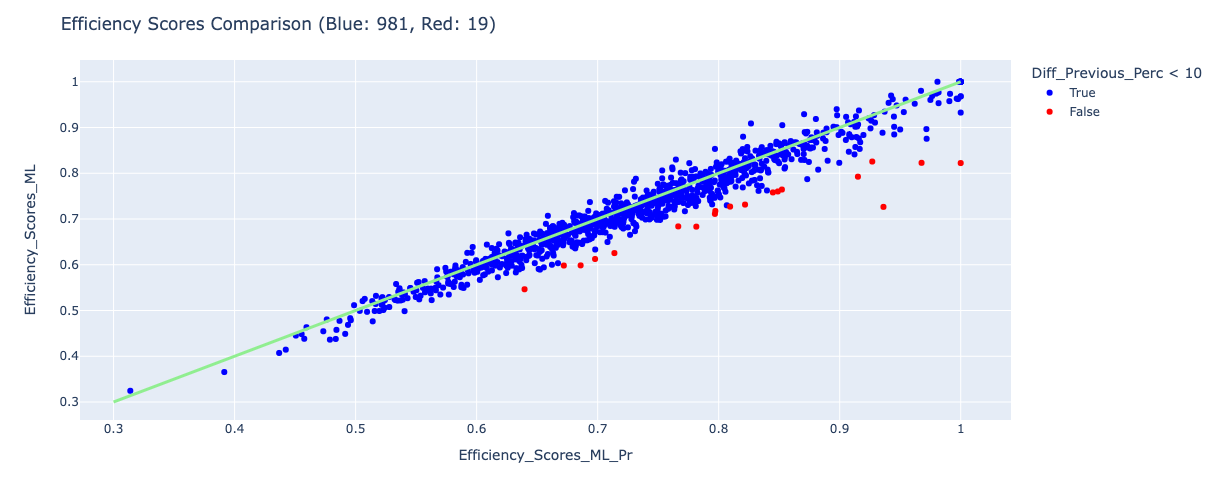

In [28]:
compareES(df_1_path="Data/Data12/US12I1O_randomforestregressor_Sol_2.xlsx", df_0_path="Data/Data12/US12I1O_randomforestregressor_Sol_1.xlsx")

### i = 3

In [29]:
i +=1
i

3

In [30]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01       1
Weight_Input 02     779
Weight_Input 03      26
Weight_Input 04     490
Weight_Input 05      91
Weight_Input 06       5
Weight_Input 07     855
Weight_Input 08       0
Weight_Input 09     220
Weight_Input 10     929
Weight_Input 11     367
Weight_Input 12     310
Weight_Output 01      0
dtype: int64
Total Zeros:  4073
neg_mean_squared_error: -0.0013556585178744235
neg_root_mean_squared_error: -0.0366217018665031
r2: 0.892250972095219
grid.best_score:  -0.03653132679809976
grid.best_params:  {'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 100, 'randomforestregressor__bootstrap': True}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=2,
         

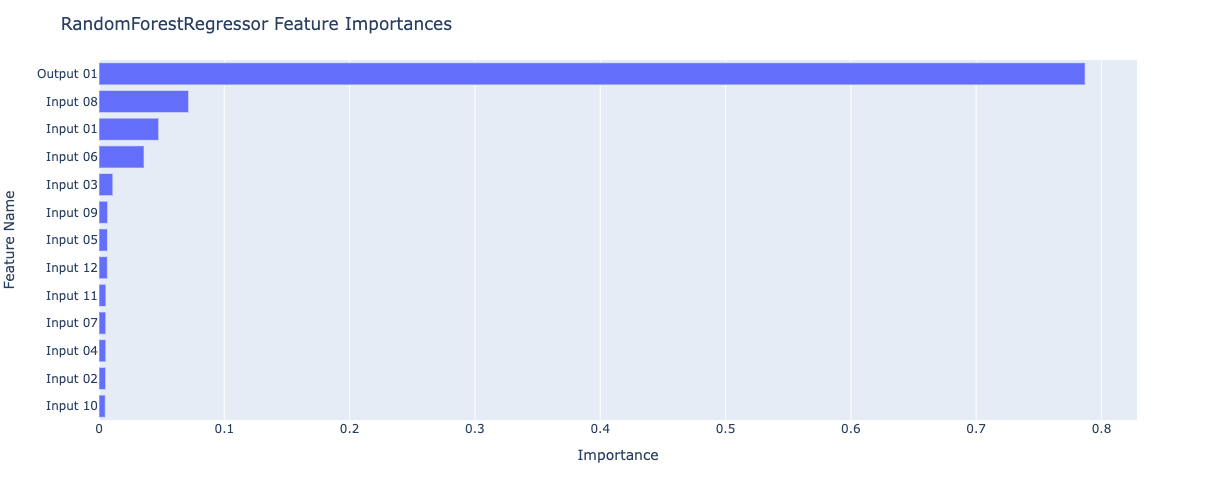

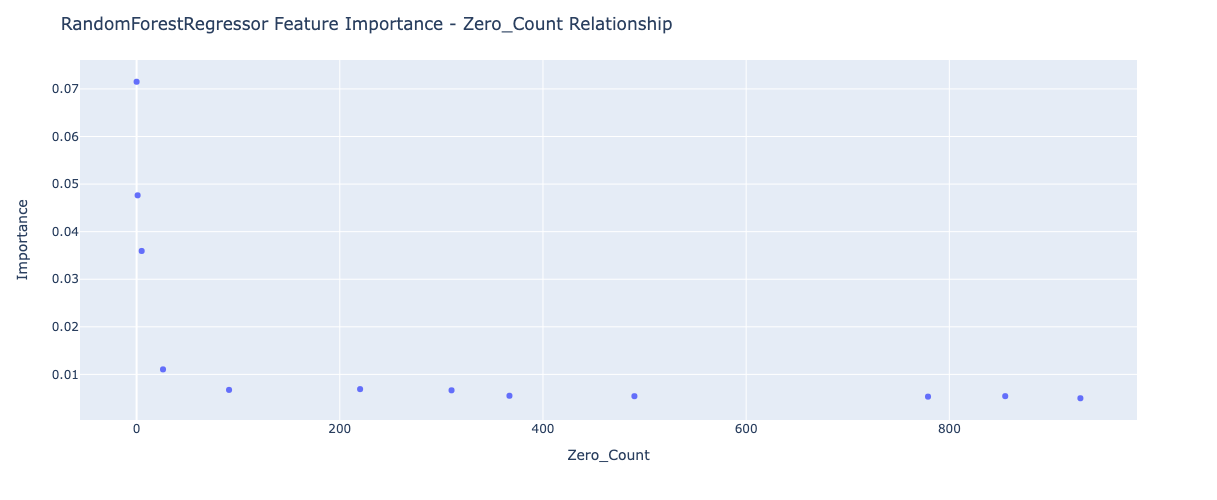

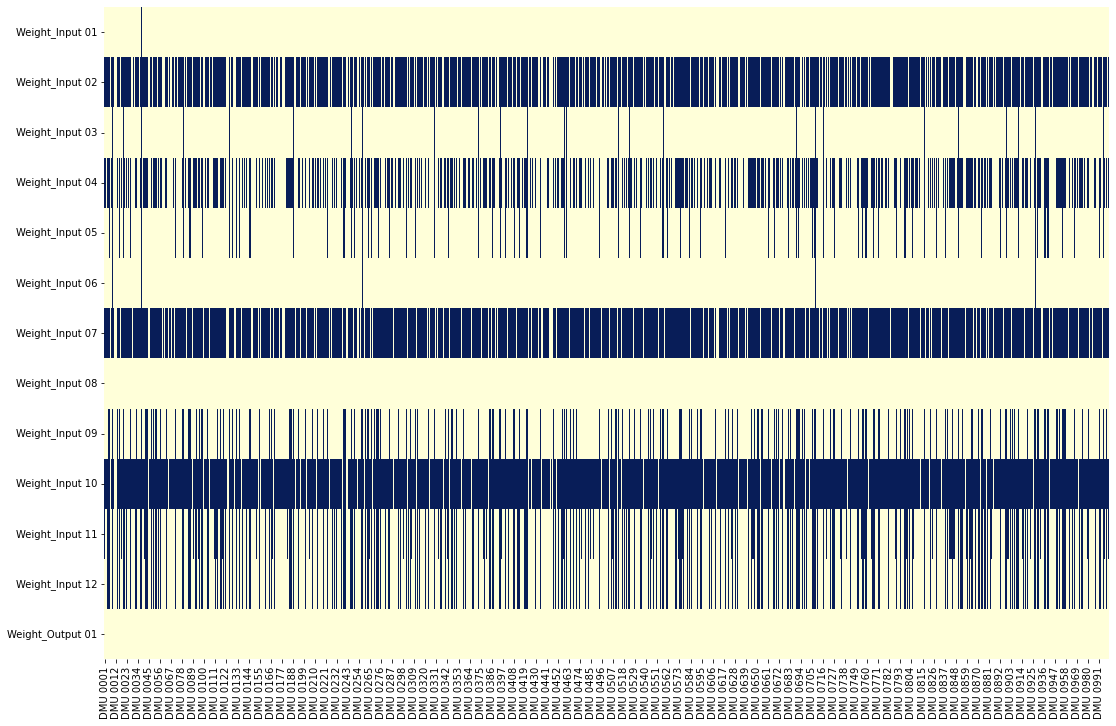

In [31]:
pipe_rf, r, y,df_merged = ml(sol_filepath="Data/Data12/US12I1O_randomforestregressor_Sol_3.xlsx", i=i)
results.append(r)

In [32]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.742394  Output 01           0          0
1      Input 08    0.042123   Input 08         428          0
2      Input 09    0.035544   Input 09         599          0
3      Input 01    0.032683   Input 01         330          0
4      Input 03    0.029812   Input 03         249          0
5      Input 06    0.024740   Input 06         396          0
6      Input 07    0.023341   Input 07         673          0
7      Input 11    0.018104   Input 11         742          0
8      Input 04    0.018087   Input 04         717          0
9      Input 10    0.009492   Input 10         830          0
10     Input 02    0.008366   Input 02         801          0
11     Input 05    0.007752   Input 05         681          0
12     Input 12    0.007562   Input 12         757          0
13    Output 01    0.764417  Output 01           0          1
14     Input 08    0.115076   Input 08           0          1
15     Input 01    0.035439   Input 01           1          1
16     Input 06    0.014850   Input 06          95          1
17     Input 03    0.011979   Input 03           9          1
18     Input 12    0.009376   Input 12         878          1
19     Input 09    0.008895   Input 09           1          1
20     Input 11    0.008606   Input 11         287          1
21     Input 10    0.008599   Input 10         651          1
22     Input 04    0.006395   Input 04         453          1
23     Input 05    0.006317   Input 05         851          1
24     Input 07    0.005122   Input 07         255          1
25     Input 02    0.004928   Input 02         798          1
26    Output 01    0.784254  Output 01           0          2
27     Input 08    0.072699   Input 08           0          2
28     Input 01    0.048047   Input 01           1          2
29     Input 06    0.036244   Input 06           4          2
30     Input 03    0.010178   Input 03          21          2
31     Input 05    0.008460   Input 05         454          2
32     Input 09    0.006532   Input 09         177          2
33     Input 12    0.006130   Input 12          72          2
34     Input 11    0.006051   Input 11         198          2
35     Input 04    0.005611   Input 04         330          2
36     Input 02    0.005555   Input 02         923          2
37     Input 07    0.005201   Input 07         546          2
38     Input 10    0.005039   Input 10         282          2
39    Output 01    0.786942  Output 01           0          3
40     Input 08    0.071505   Input 08           0          3
41     Input 01    0.047631   Input 01           1          3
42     Input 06    0.035938   Input 06           5          3
43     Input 03    0.011050   Input 03          26          3
44     Input 09    0.006900   Input 09         220          3
45     Input 05    0.006738   Input 05          91          3
46     Input 12    0.006649   Input 12         310          3
47     Input 11    0.005506   Input 11         367          3
48     Input 07    0.005423   Input 07         855          3
49     Input 04    0.005416   Input 04         490          3
50     Input 02    0.005321   Input 02         779          3
51     Input 10    0.004982   Input 10         929          3

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6576  0.6710 -0.0134     -1.9928            True
1        0.6581  0.6290  0.0290      4.6168           False
2        0.8289  0.8129  0.0160      1.9693            True
3        0.8490  0.8339  0.0151      1.8107            True
4        0.7278  0.7839 -0.0562     -7.1639           False
..          ...     ...     ...         ...             ...
195      0.7180  0.7370 -0.0190     -2.5763            True
196      0.8297  0.8280  0.0017      0.2101            True
197      0.7675  0.7845 -0.0170     -2.1669            True
198      0.7778  0.8494 -0.0717     -8.4364           False
199      0.7863  0.8261 -0.0398     -4.8233           False

[200 rows x 5 columns]
blue:  93
red:  107
rho: 0.9438
p-Value 0.0


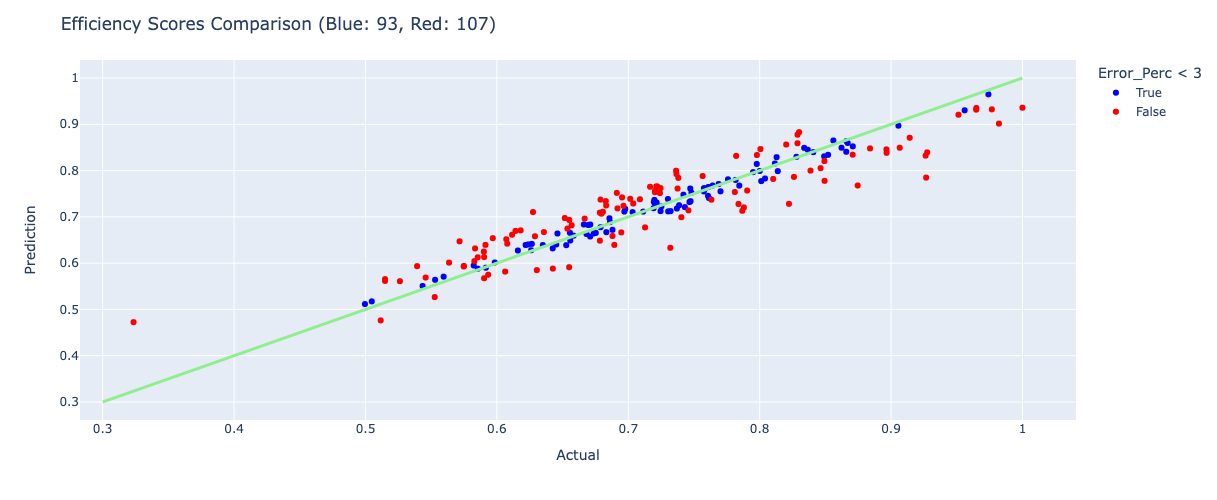

In [33]:
compareML(pipe_rf, y)

blue :  547
red :  453


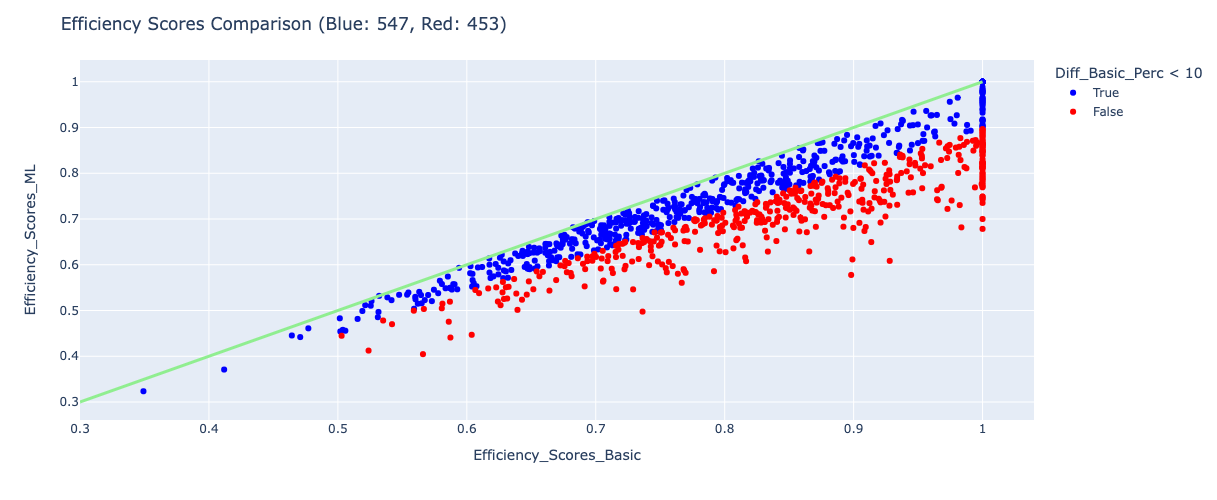

blue :  999
red :  1


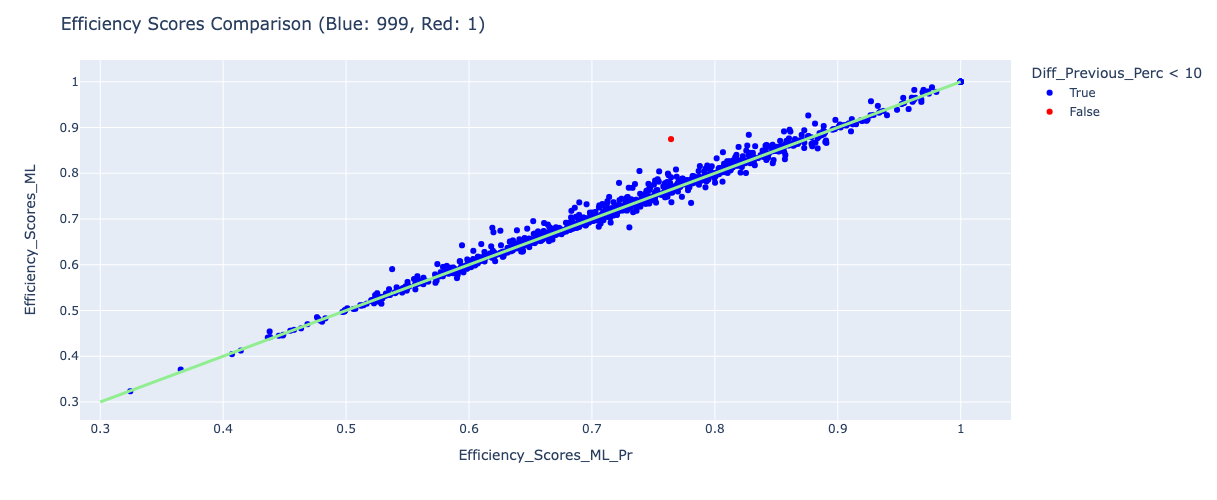

In [34]:
compareES(df_1_path="Data/Data12/US12I1O_randomforestregressor_Sol_3.xlsx", df_0_path="Data/Data12/US12I1O_randomforestregressor_Sol_2.xlsx")

### i = 4

In [35]:
i +=1
i

4

In [36]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01       1
Weight_Input 02     831
Weight_Input 03      27
Weight_Input 04     502
Weight_Input 05     105
Weight_Input 06       5
Weight_Input 07     352
Weight_Input 08       0
Weight_Input 09      75
Weight_Input 10     934
Weight_Input 11     319
Weight_Input 12     267
Weight_Output 01      0
dtype: int64
Total Zeros:  3418
neg_mean_squared_error: -0.0013299125630562617
neg_root_mean_squared_error: -0.03627860598119156
r2: 0.8944317529336159
grid.best_score:  -0.03633361227340141
grid.best_params:  {'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 100, 'randomforestregressor__bootstrap': True}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=2,
       

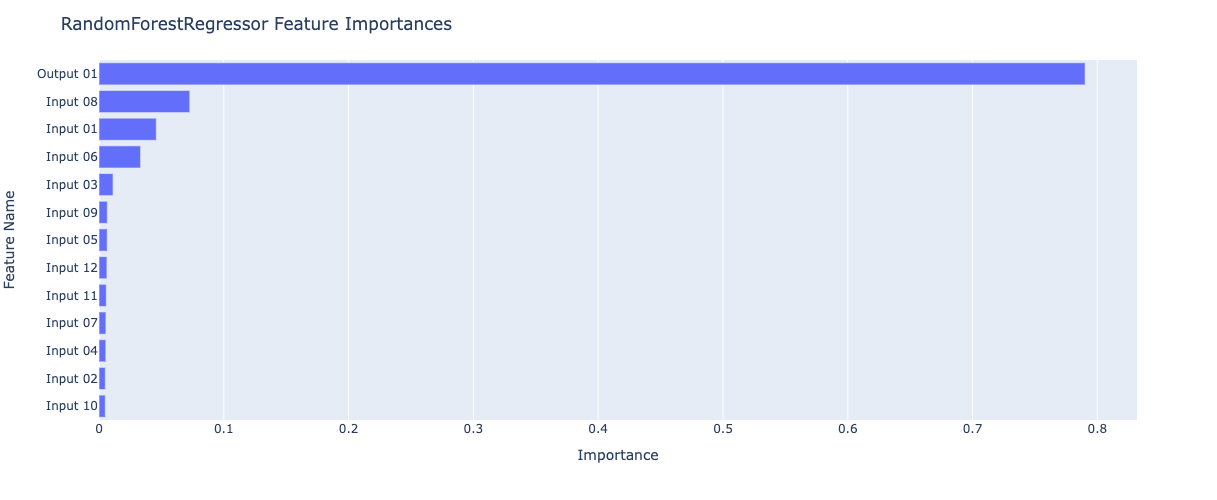

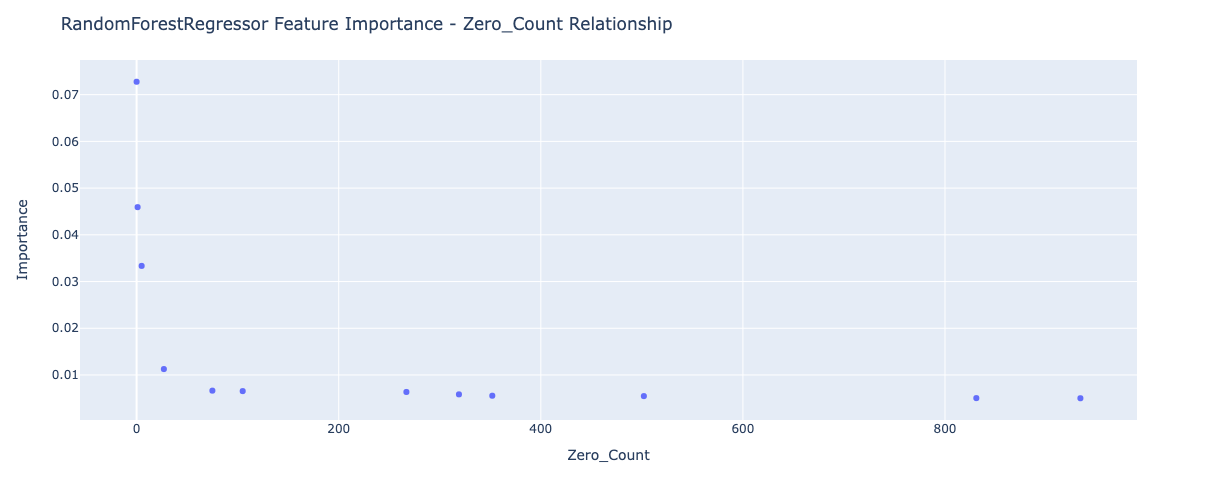

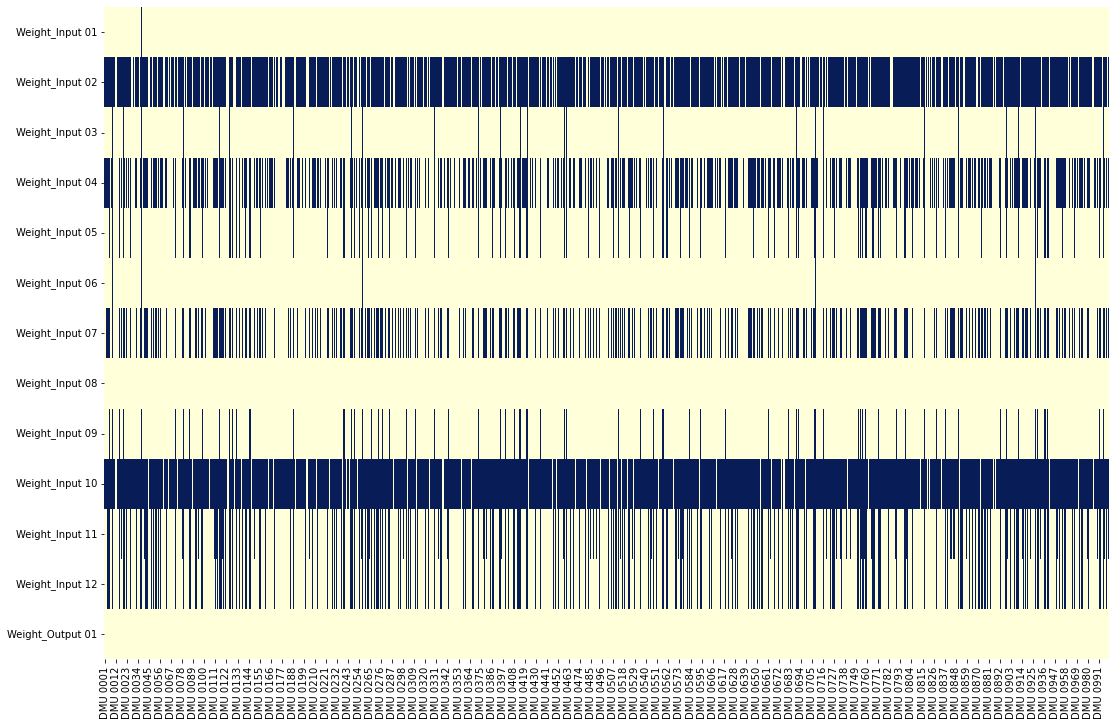

In [37]:
pipe_rf, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_randomforestregressor_Sol_4.xlsx", i=i)
results.append(r)

In [38]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.742394  Output 01           0          0
1      Input 08    0.042123   Input 08         428          0
2      Input 09    0.035544   Input 09         599          0
3      Input 01    0.032683   Input 01         330          0
4      Input 03    0.029812   Input 03         249          0
..          ...         ...        ...         ...        ...
60     Input 11    0.005850   Input 11         319          4
61     Input 07    0.005560   Input 07         352          4
62     Input 04    0.005479   Input 04         502          4
63     Input 02    0.005048   Input 02         831          4
64     Input 10    0.005018   Input 10         934          4

[65 rows x 5 columns]

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6530  0.6710 -0.0180     -2.6843            True
1        0.6629  0.6328  0.0301      4.7578           False
2        0.8330  0.8348 -0.0018     -0.2165            True
3        0.8547  0.8347  0.0199      2.3892            True
4        0.7291  0.7839 -0.0548     -6.9940           False
..          ...     ...     ...         ...             ...
195      0.7187  0.7370 -0.0182     -2.4763            True
196      0.8383  0.8267  0.0116      1.4088            True
197      0.7754  0.7893 -0.0139     -1.7651            True
198      0.7779  0.8494 -0.0715     -8.4204           False
199      0.7883  0.8261 -0.0378     -4.5807           False

[200 rows x 5 columns]
blue:  95
red:  105
rho: 0.9483
p-Value 0.0


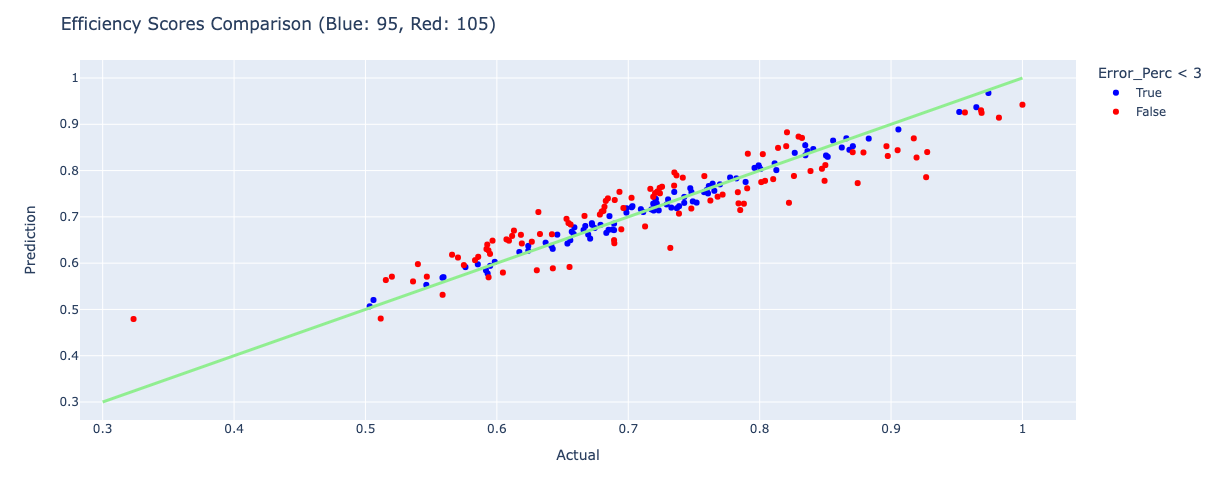

In [39]:
compareML(pipe_rf, y)

blue :  554
red :  446


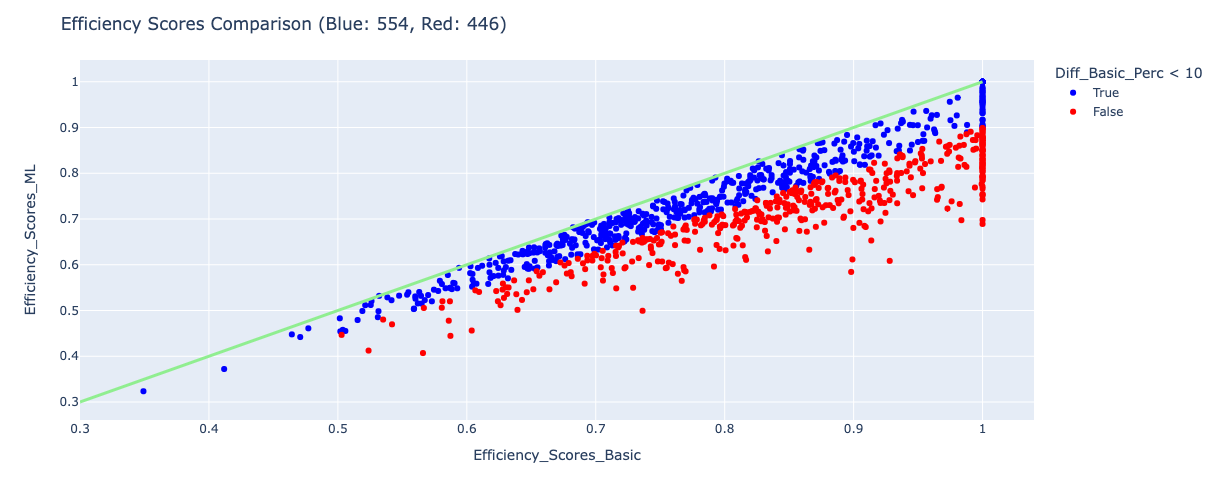

blue :  1000
red :  0


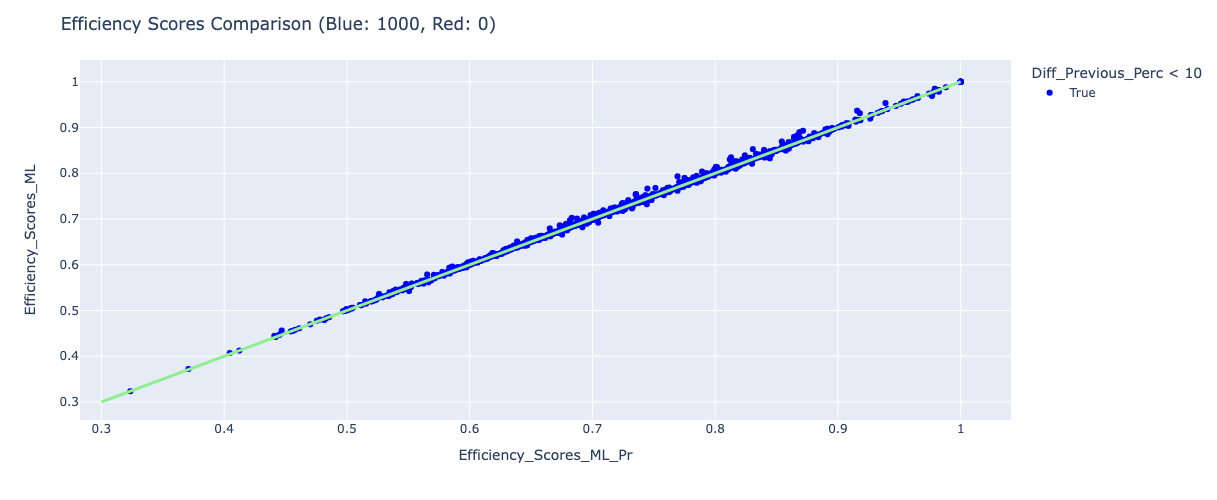

In [40]:
compareES(df_1_path="Data/Data12/US12I1O_randomforestregressor_Sol_4.xlsx", df_0_path="Data/Data12/US12I1O_randomforestregressor_Sol_3.xlsx")

### i = 5

In [41]:
i +=1
i

5

In [42]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01       1
Weight_Input 02     831
Weight_Input 03      27
Weight_Input 04     502
Weight_Input 05     105
Weight_Input 06       5
Weight_Input 07     352
Weight_Input 08       0
Weight_Input 09      75
Weight_Input 10     934
Weight_Input 11     319
Weight_Input 12     267
Weight_Output 01      0
dtype: int64
Total Zeros:  3418
neg_mean_squared_error: -0.0013299125630562617
neg_root_mean_squared_error: -0.03627860598119156
r2: 0.8944317529336159
grid.best_score:  -0.03633361227340141
grid.best_params:  {'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 100, 'randomforestregressor__bootstrap': True}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=2,
       

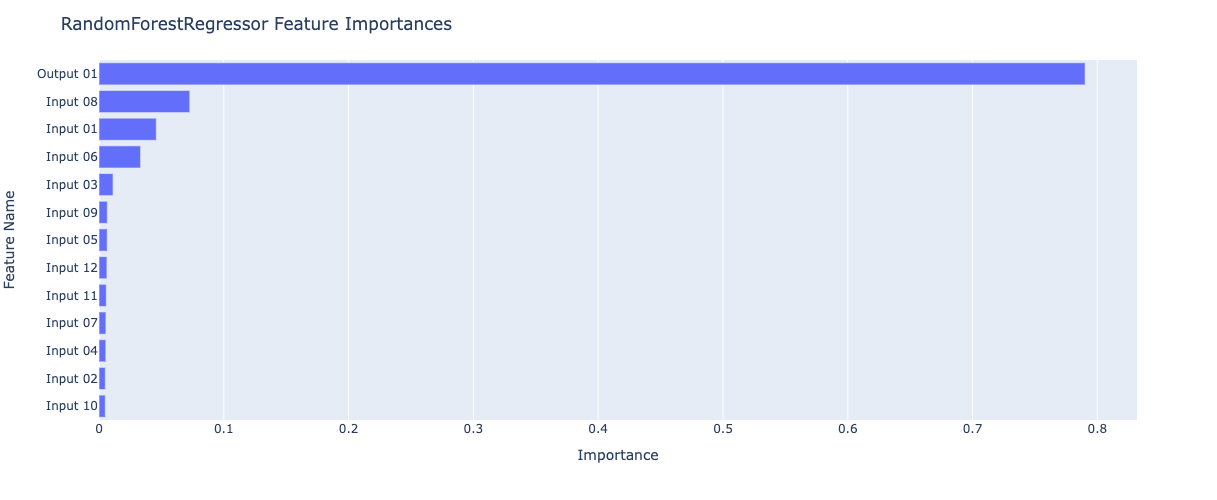

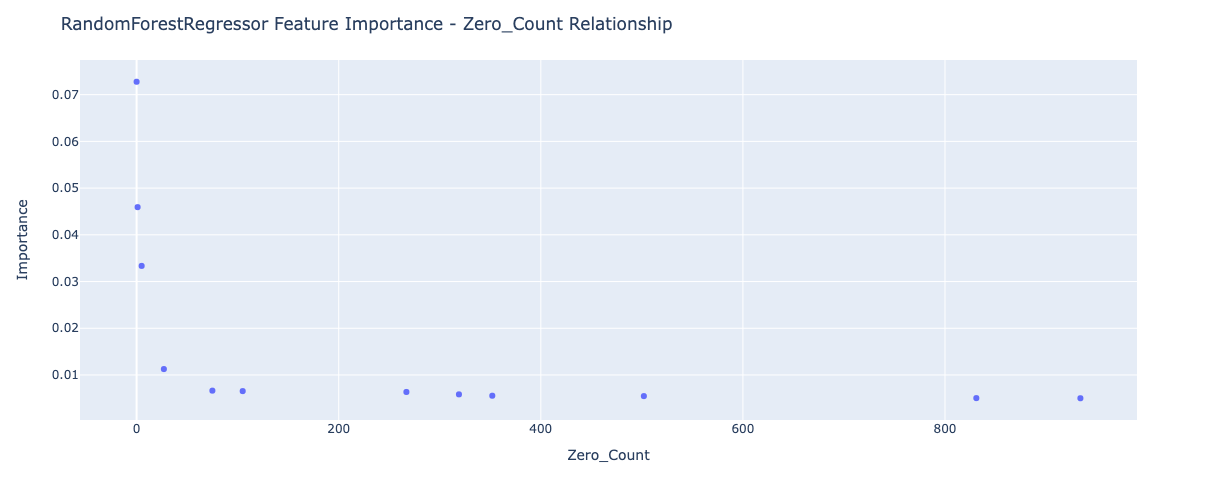

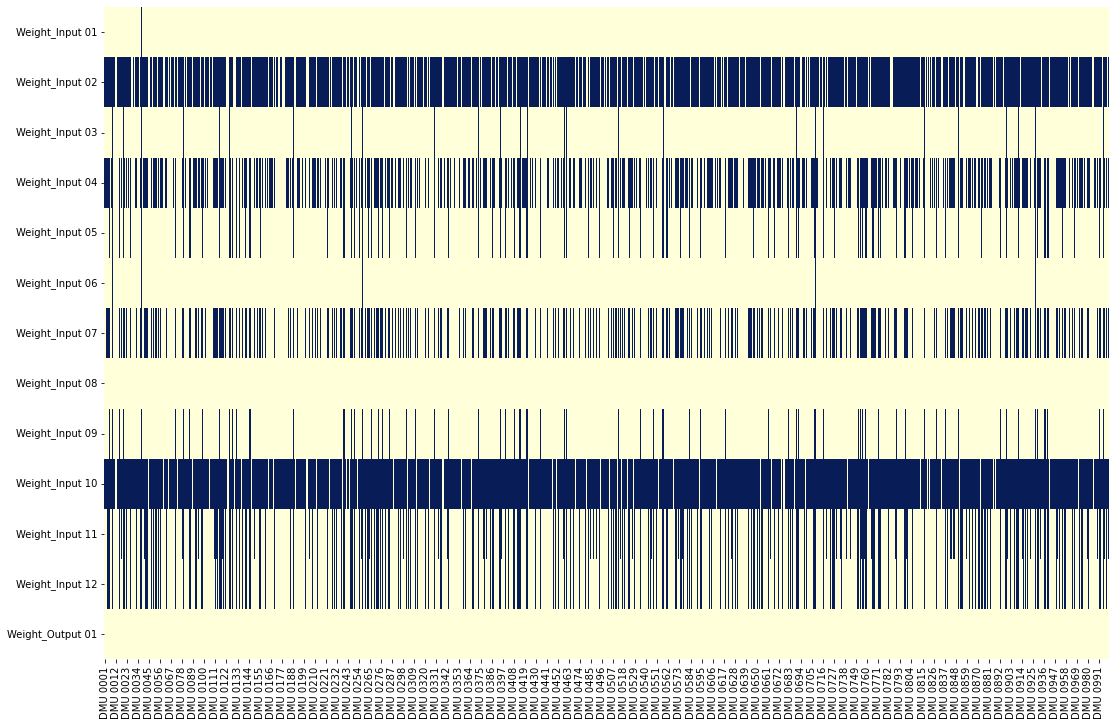

In [43]:
pipe_rf, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_randomforestregressor_Sol_5.xlsx", i=i)
results.append(r)

In [44]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.742394  Output 01           0          0
1      Input 08    0.042123   Input 08         428          0
2      Input 09    0.035544   Input 09         599          0
3      Input 01    0.032683   Input 01         330          0
4      Input 03    0.029812   Input 03         249          0
..          ...         ...        ...         ...        ...
73     Input 11    0.005850   Input 11         319          5
74     Input 07    0.005560   Input 07         352          5
75     Input 04    0.005479   Input 04         502          5
76     Input 02    0.005048   Input 02         831          5
77     Input 10    0.005018   Input 10         934          5

[78 rows x 5 columns]

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6530  0.6710 -0.0180     -2.6843            True
1        0.6629  0.6328  0.0301      4.7578           False
2        0.8330  0.8348 -0.0018     -0.2165            True
3        0.8547  0.8347  0.0199      2.3892            True
4        0.7291  0.7839 -0.0548     -6.9940           False
..          ...     ...     ...         ...             ...
195      0.7187  0.7370 -0.0182     -2.4763            True
196      0.8383  0.8267  0.0116      1.4088            True
197      0.7754  0.7893 -0.0139     -1.7651            True
198      0.7779  0.8494 -0.0715     -8.4204           False
199      0.7883  0.8261 -0.0378     -4.5807           False

[200 rows x 5 columns]
blue:  95
red:  105
rho: 0.9483
p-Value 0.0


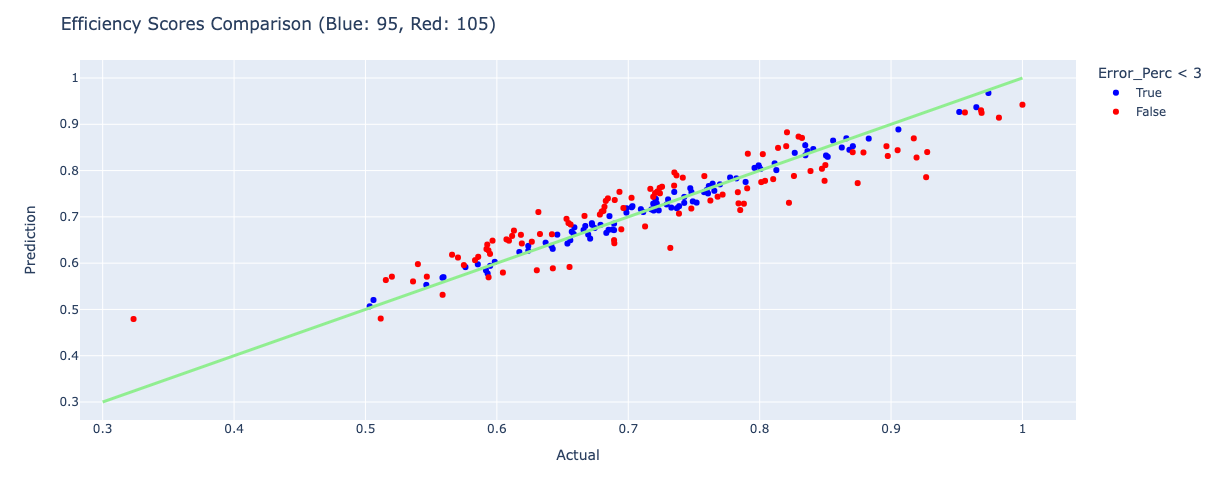

In [45]:
compareML(pipe_rf, y)

blue :  554
red :  446


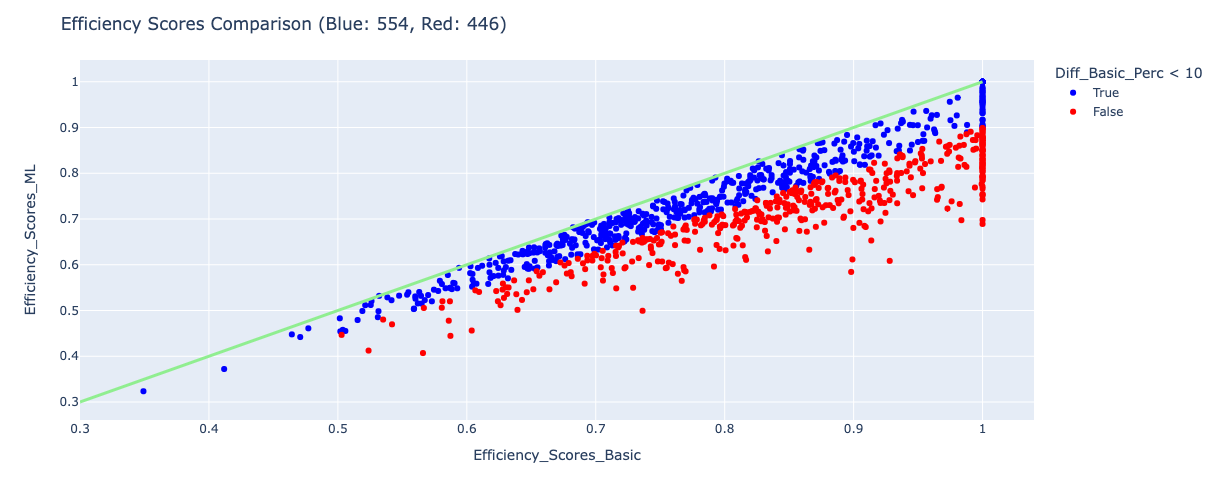

blue :  1000
red :  0


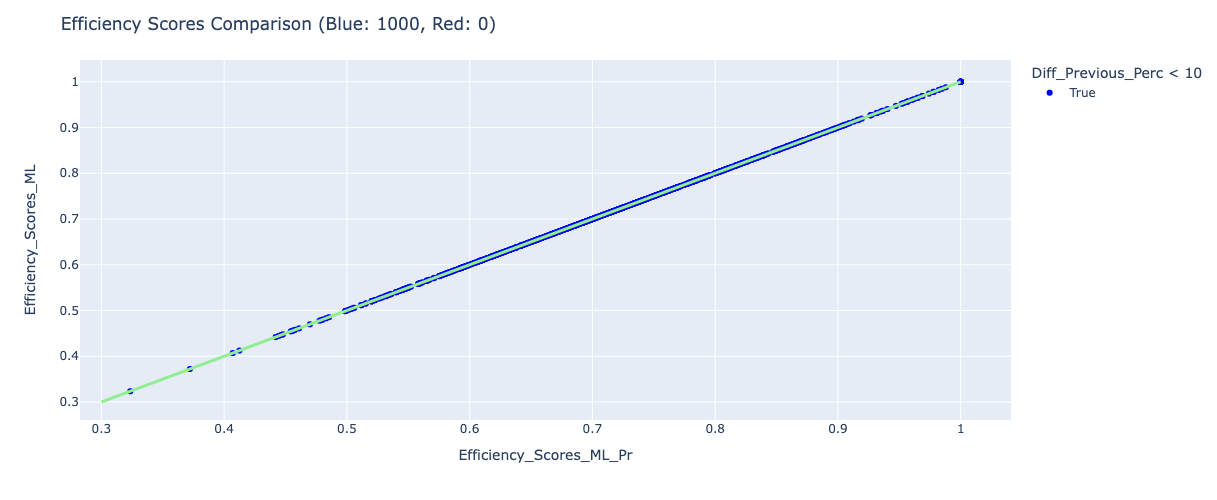

In [46]:
compareES(df_1_path="Data/Data12/US12I1O_randomforestregressor_Sol_5.xlsx", df_0_path="Data/Data12/US12I1O_randomforestregressor_Sol_4.xlsx")

### i = 6

In [47]:
i +=1
i

6

In [48]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01       1
Weight_Input 02     831
Weight_Input 03      27
Weight_Input 04     502
Weight_Input 05     105
Weight_Input 06       5
Weight_Input 07     352
Weight_Input 08       0
Weight_Input 09      75
Weight_Input 10     934
Weight_Input 11     319
Weight_Input 12     267
Weight_Output 01      0
dtype: int64
Total Zeros:  3418
neg_mean_squared_error: -0.0013299125630562617
neg_root_mean_squared_error: -0.03627860598119156
r2: 0.8944317529336159
grid.best_score:  -0.03633361227340141
grid.best_params:  {'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 100, 'randomforestregressor__bootstrap': True}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=2,
       

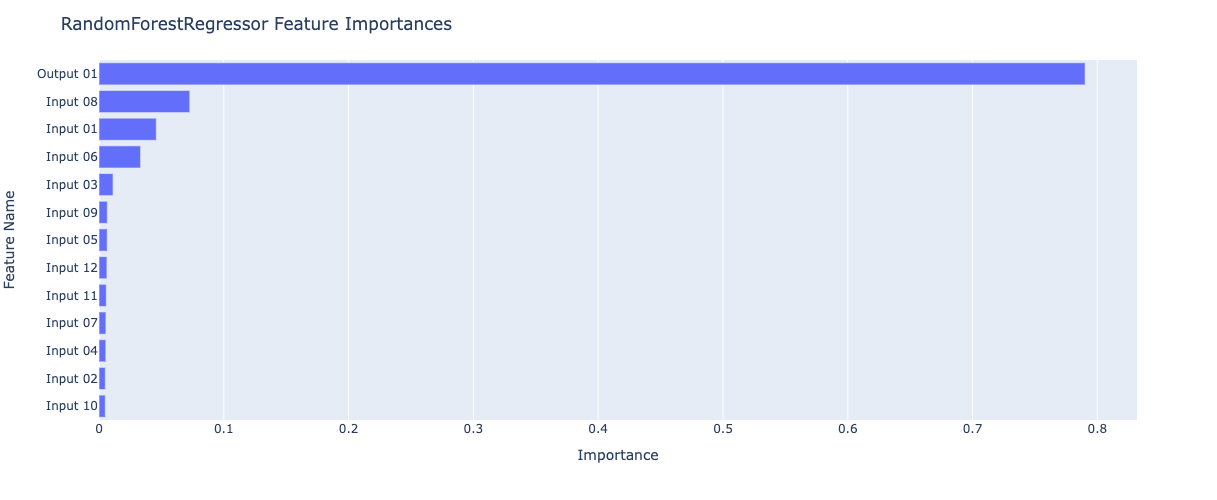

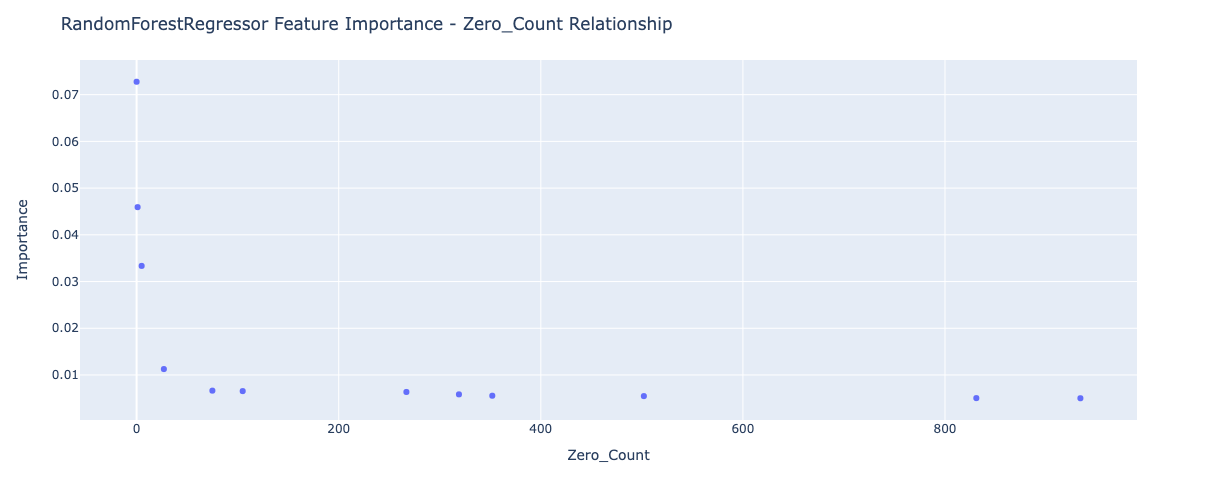

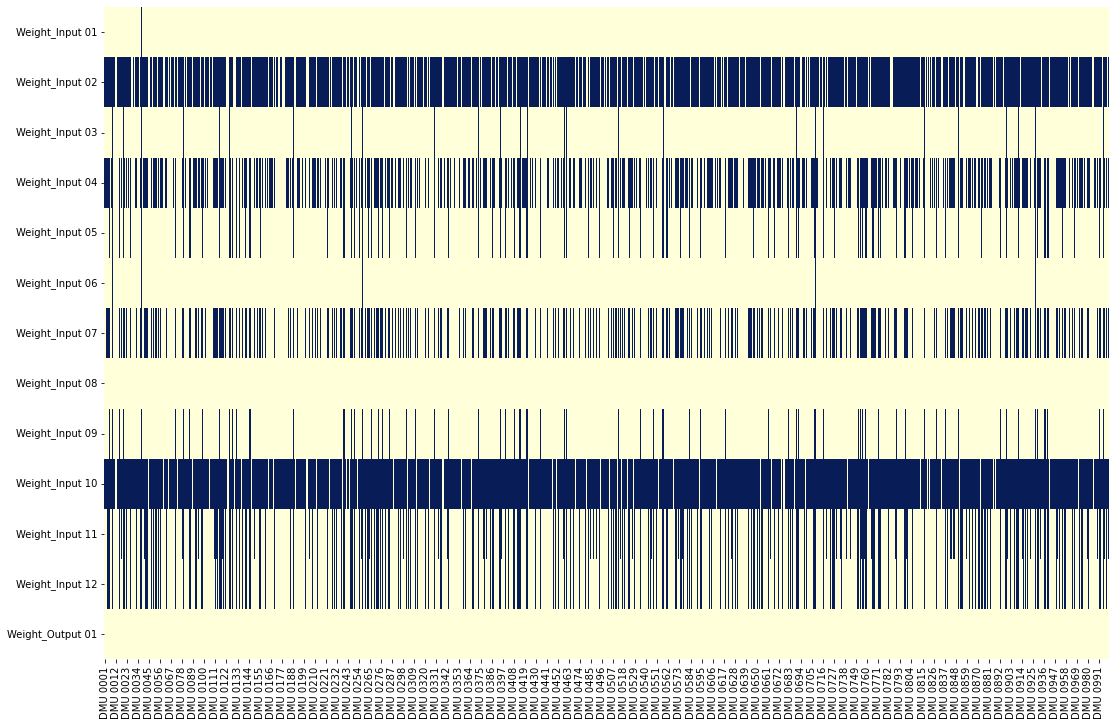

In [49]:
pipe_rf, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_randomforestregressor_Sol_6.xlsx", i=i)
results.append(r)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6530  0.6710 -0.0180     -2.6843            True
1        0.6629  0.6328  0.0301      4.7578           False
2        0.8330  0.8348 -0.0018     -0.2165            True
3        0.8547  0.8347  0.0199      2.3892            True
4        0.7291  0.7839 -0.0548     -6.9940           False
..          ...     ...     ...         ...             ...
195      0.7187  0.7370 -0.0182     -2.4763            True
196      0.8383  0.8267  0.0116      1.4088            True
197      0.7754  0.7893 -0.0139     -1.7651            True
198      0.7779  0.8494 -0.0715     -8.4204           False
199      0.7883  0.8261 -0.0378     -4.5807           False

[200 rows x 5 columns]
blue:  95
red:  105
rho: 0.9483
p-Value 0.0


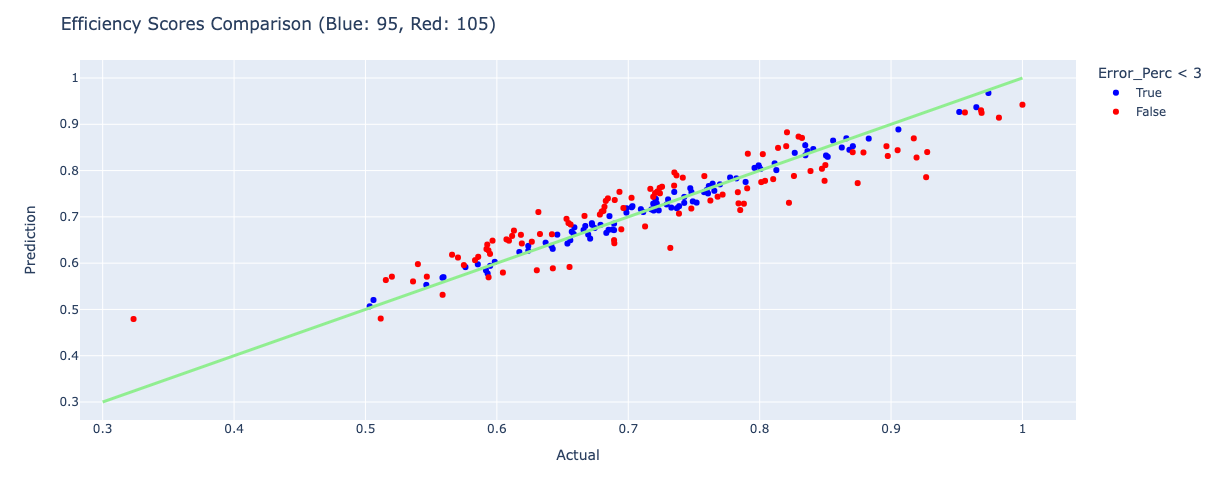

In [50]:
compareML(pipe_rf, y)

In [51]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.742394  Output 01           0          0
1      Input 08    0.042123   Input 08         428          0
2      Input 09    0.035544   Input 09         599          0
3      Input 01    0.032683   Input 01         330          0
4      Input 03    0.029812   Input 03         249          0
..          ...         ...        ...         ...        ...
86     Input 11    0.005850   Input 11         319          6
87     Input 07    0.005560   Input 07         352          6
88     Input 04    0.005479   Input 04         502          6
89     Input 02    0.005048   Input 02         831          6
90     Input 10    0.005018   Input 10         934          6

[91 rows x 5 columns]

blue :  554
red :  446


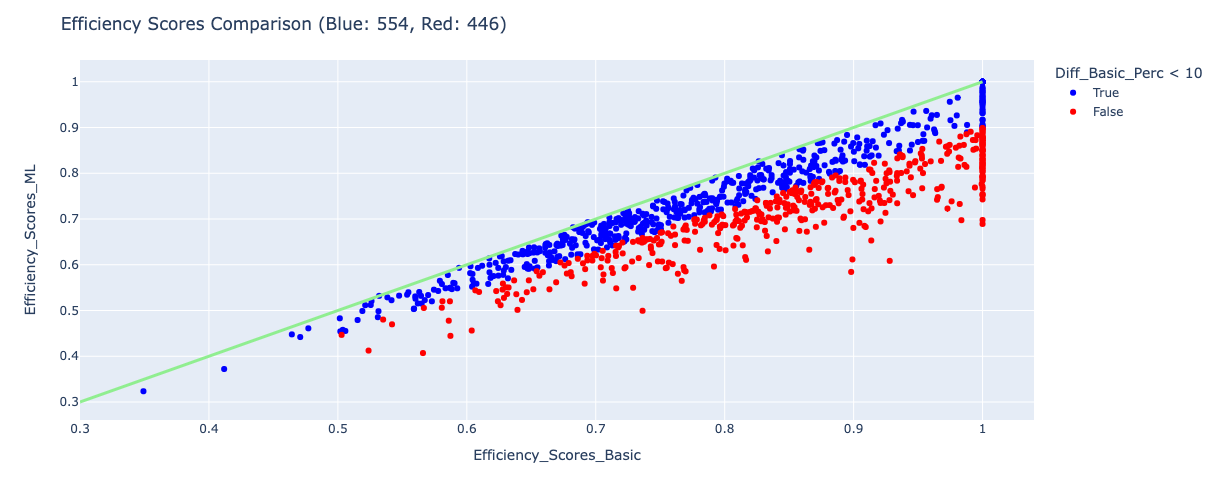

blue :  1000
red :  0


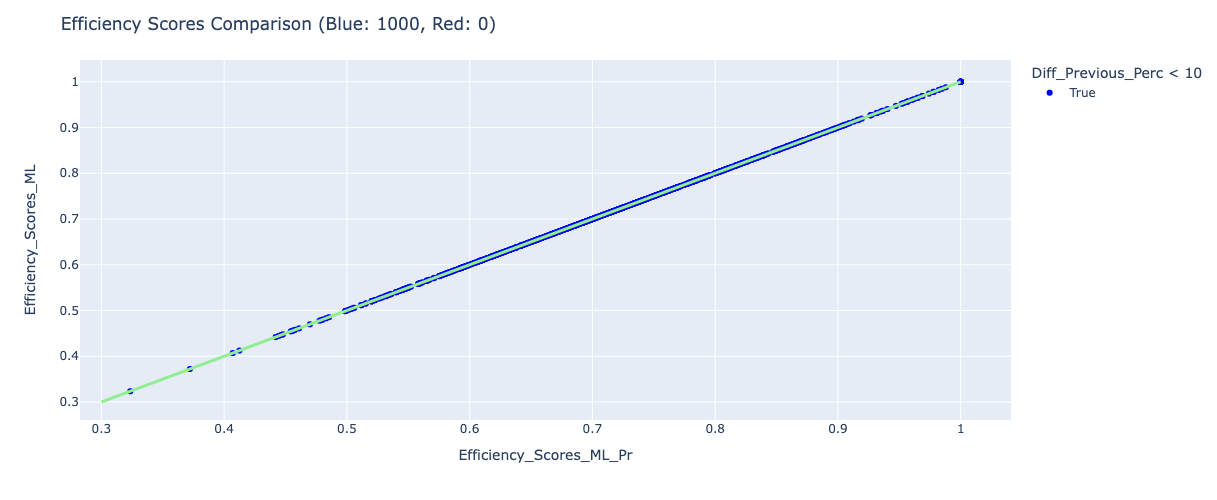

In [52]:
compareES(df_1_path="Data/Data12/US12I1O_randomforestregressor_Sol_6.xlsx", df_0_path="Data/Data12/US12I1O_randomforestregressor_Sol_5.xlsx")

### i = 7

In [53]:
i +=1
i

7

In [54]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01       1
Weight_Input 02     831
Weight_Input 03      27
Weight_Input 04     502
Weight_Input 05     105
Weight_Input 06       5
Weight_Input 07     352
Weight_Input 08       0
Weight_Input 09      75
Weight_Input 10     934
Weight_Input 11     319
Weight_Input 12     267
Weight_Output 01      0
dtype: int64
Total Zeros:  3418
neg_mean_squared_error: -0.0013299125630562617
neg_root_mean_squared_error: -0.03627860598119156
r2: 0.8944317529336159
grid.best_score:  -0.03633361227340141
grid.best_params:  {'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 100, 'randomforestregressor__bootstrap': True}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=2,
       

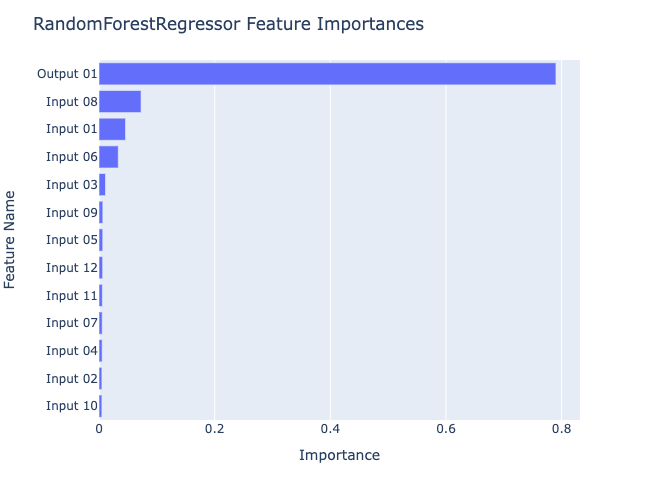

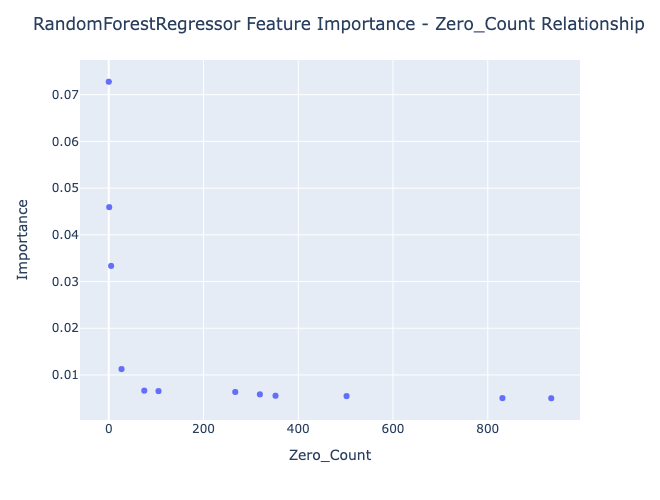

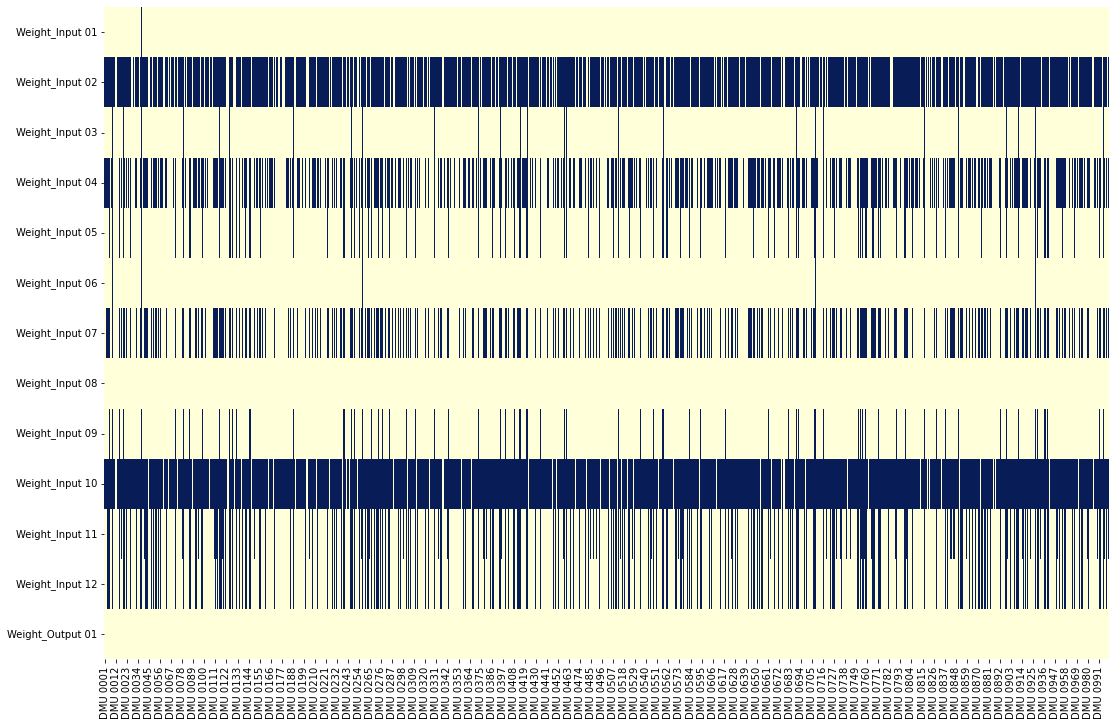

In [55]:
pipe_rf, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_randomforestregressor_Sol_7.xlsx", i=i)
results.append(r)

In [56]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0      Output 01    0.742394  Output 01           0          0
1       Input 08    0.042123   Input 08         428          0
2       Input 09    0.035544   Input 09         599          0
3       Input 01    0.032683   Input 01         330          0
4       Input 03    0.029812   Input 03         249          0
..           ...         ...        ...         ...        ...
99      Input 11    0.005850   Input 11         319          7
100     Input 07    0.005560   Input 07         352          7
101     Input 04    0.005479   Input 04         502          7
102     Input 02    0.005048   Input 02         831          7
103     Input 10    0.005018   Input 10         934          7

[104 rows x 5 columns]

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6530  0.6710 -0.0180     -2.6843            True
1        0.6629  0.6328  0.0301      4.7578           False
2        0.8330  0.8348 -0.0018     -0.2165            True
3        0.8547  0.8347  0.0199      2.3892            True
4        0.7291  0.7839 -0.0548     -6.9940           False
..          ...     ...     ...         ...             ...
195      0.7187  0.7370 -0.0182     -2.4763            True
196      0.8383  0.8267  0.0116      1.4088            True
197      0.7754  0.7893 -0.0139     -1.7651            True
198      0.7779  0.8494 -0.0715     -8.4204           False
199      0.7883  0.8261 -0.0378     -4.5807           False

[200 rows x 5 columns]
blue:  95
red:  105
rho: 0.9483
p-Value 0.0


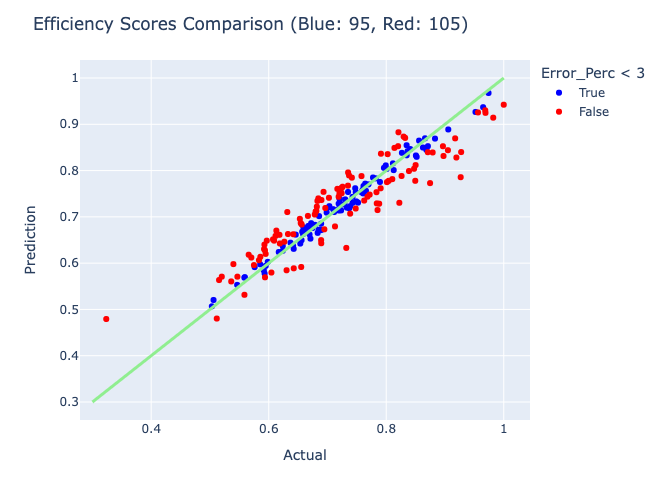

In [57]:
compareML(pipe_rf, y)

blue :  554
red :  446


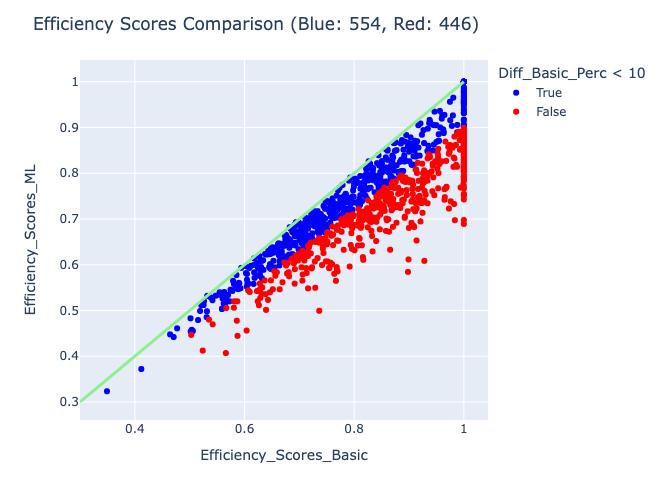

blue :  1000
red :  0


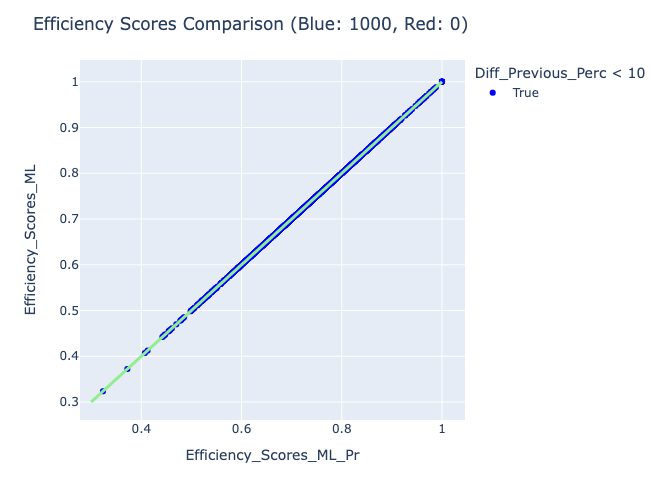

In [58]:
compareES(df_1_path="Data/Data12/US12I1O_randomforestregressor_Sol_7.xlsx", df_0_path="Data/Data12/US12I1O_randomforestregressor_Sol_6.xlsx")

### i = 8

In [59]:
i +=1
i

8

In [60]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01       1
Weight_Input 02     831
Weight_Input 03      27
Weight_Input 04     502
Weight_Input 05     105
Weight_Input 06       5
Weight_Input 07     352
Weight_Input 08       0
Weight_Input 09      75
Weight_Input 10     934
Weight_Input 11     319
Weight_Input 12     267
Weight_Output 01      0
dtype: int64
Total Zeros:  3418
neg_mean_squared_error: -0.0013299125630562617
neg_root_mean_squared_error: -0.03627860598119156
r2: 0.8944317529336159
grid.best_score:  -0.03633361227340141
grid.best_params:  {'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 100, 'randomforestregressor__bootstrap': True}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=2,
       

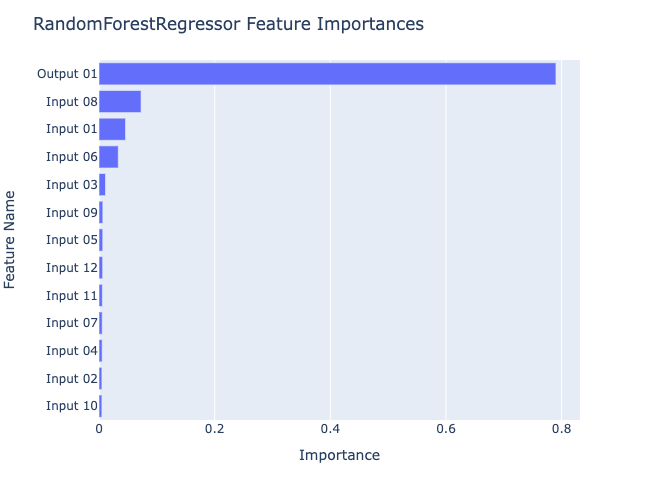

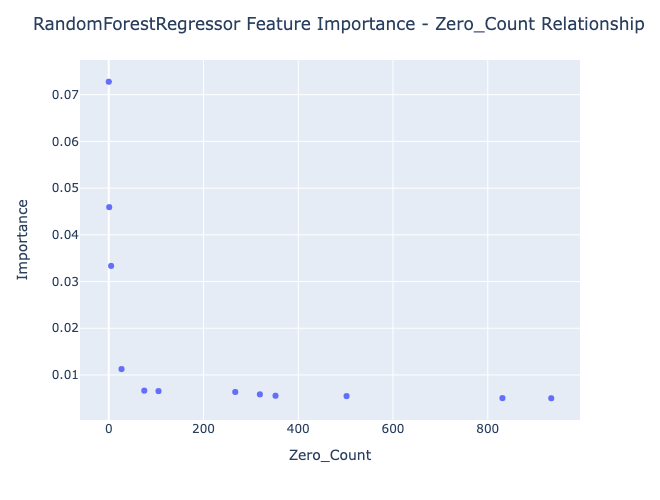

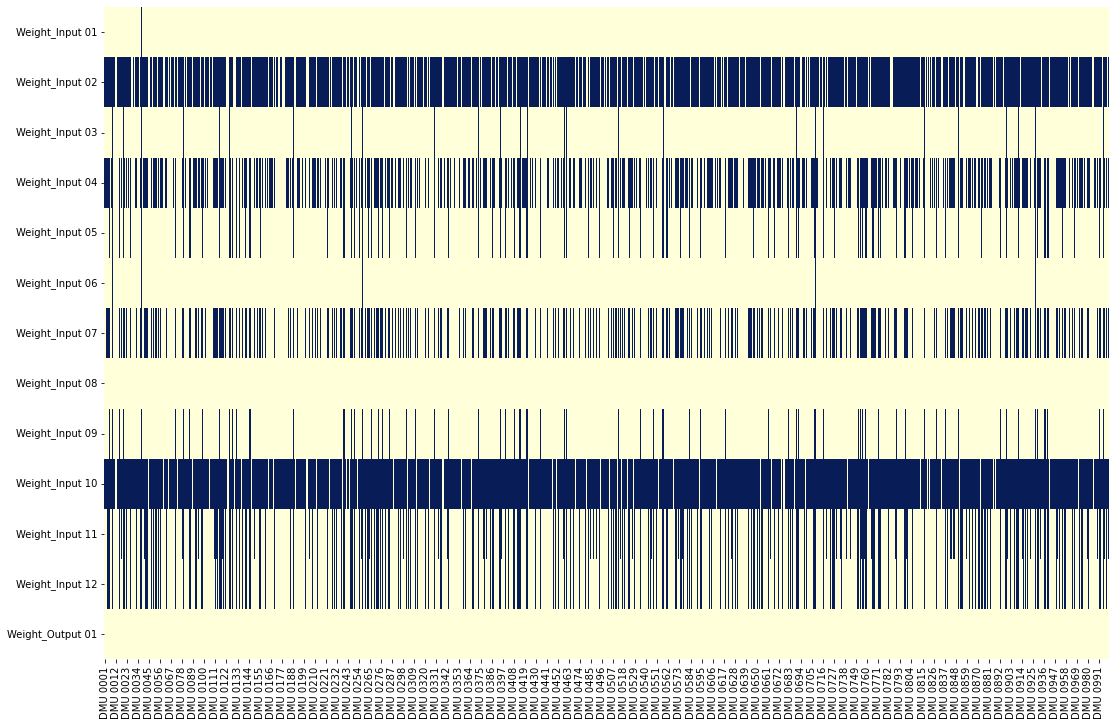

In [61]:
pipe_rf, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_randomforestregressor_Sol_8.xlsx", i=i)
results.append(r)

In [62]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0      Output 01    0.742394  Output 01           0          0
1       Input 08    0.042123   Input 08         428          0
2       Input 09    0.035544   Input 09         599          0
3       Input 01    0.032683   Input 01         330          0
4       Input 03    0.029812   Input 03         249          0
..           ...         ...        ...         ...        ...
112     Input 11    0.005850   Input 11         319          8
113     Input 07    0.005560   Input 07         352          8
114     Input 04    0.005479   Input 04         502          8
115     Input 02    0.005048   Input 02         831          8
116     Input 10    0.005018   Input 10         934          8

[117 rows x 5 columns]

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6530  0.6710 -0.0180     -2.6843            True
1        0.6629  0.6328  0.0301      4.7578           False
2        0.8330  0.8348 -0.0018     -0.2165            True
3        0.8547  0.8347  0.0199      2.3892            True
4        0.7291  0.7839 -0.0548     -6.9940           False
..          ...     ...     ...         ...             ...
195      0.7187  0.7370 -0.0182     -2.4763            True
196      0.8383  0.8267  0.0116      1.4088            True
197      0.7754  0.7893 -0.0139     -1.7651            True
198      0.7779  0.8494 -0.0715     -8.4204           False
199      0.7883  0.8261 -0.0378     -4.5807           False

[200 rows x 5 columns]
blue:  95
red:  105
rho: 0.9483
p-Value 0.0


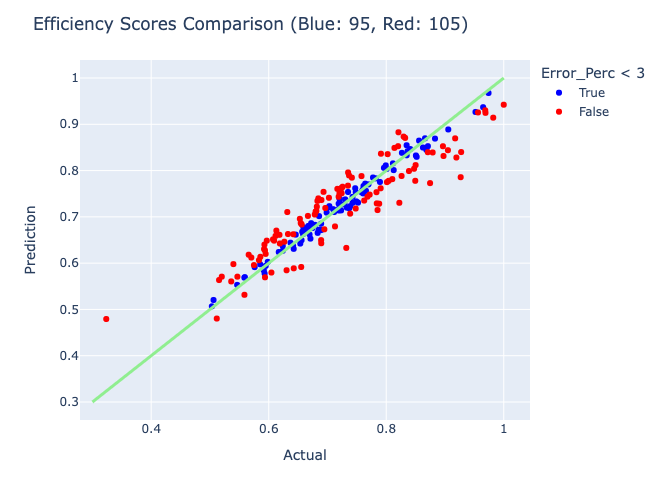

In [63]:
compareML(pipe_rf, y)

blue :  554
red :  446


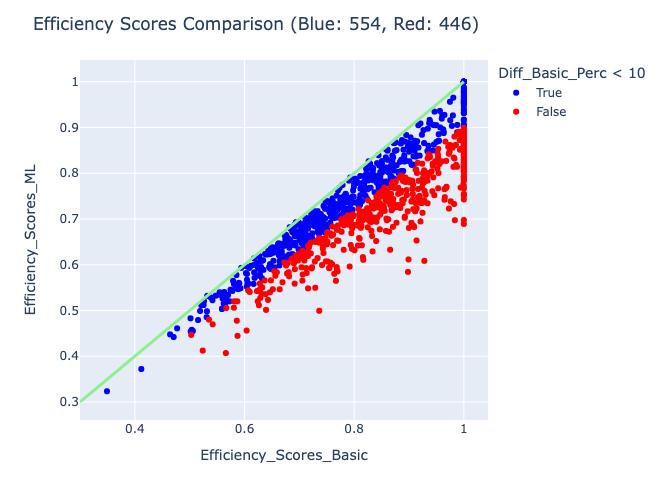

blue :  1000
red :  0


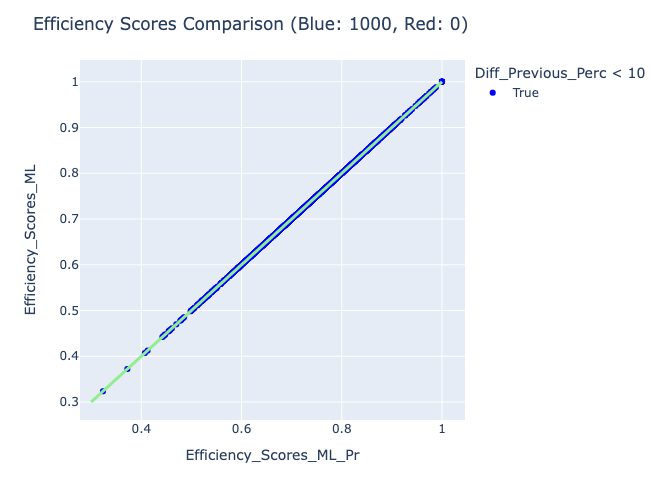

In [64]:
compareES(df_1_path="Data/Data12/US12I1O_randomforestregressor_Sol_8.xlsx", df_0_path="Data/Data12/US12I1O_randomforestregressor_Sol_7.xlsx")

### i = 9

In [65]:
i +=1
i

9

In [66]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01       1
Weight_Input 02     831
Weight_Input 03      27
Weight_Input 04     502
Weight_Input 05     105
Weight_Input 06       5
Weight_Input 07     352
Weight_Input 08       0
Weight_Input 09      75
Weight_Input 10     934
Weight_Input 11     319
Weight_Input 12     267
Weight_Output 01      0
dtype: int64
Total Zeros:  3418
neg_mean_squared_error: -0.0013299125630562617
neg_root_mean_squared_error: -0.03627860598119156
r2: 0.8944317529336159
grid.best_score:  -0.03633361227340141
grid.best_params:  {'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 100, 'randomforestregressor__bootstrap': True}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=2,
       

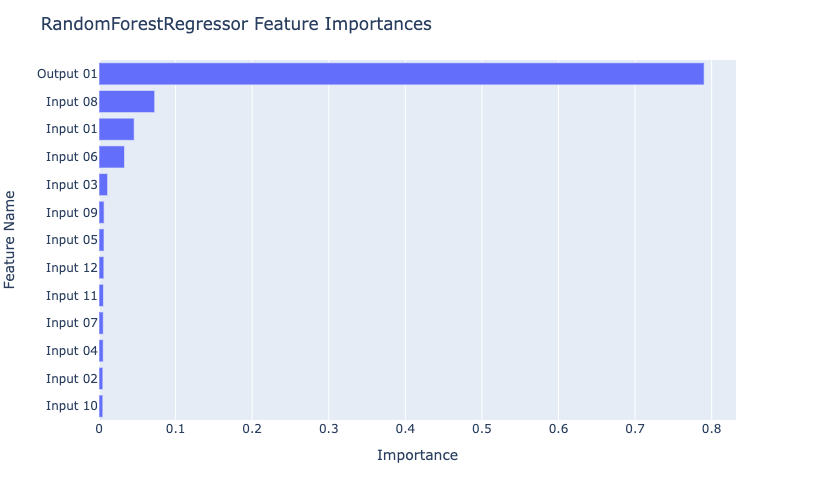

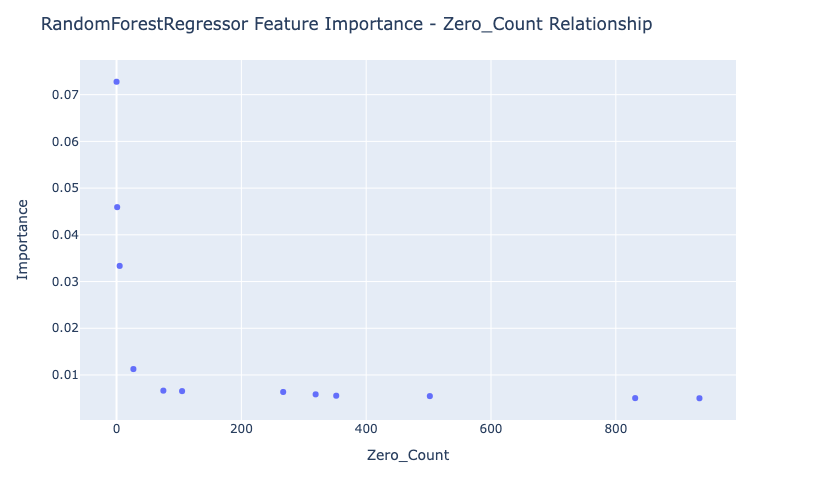

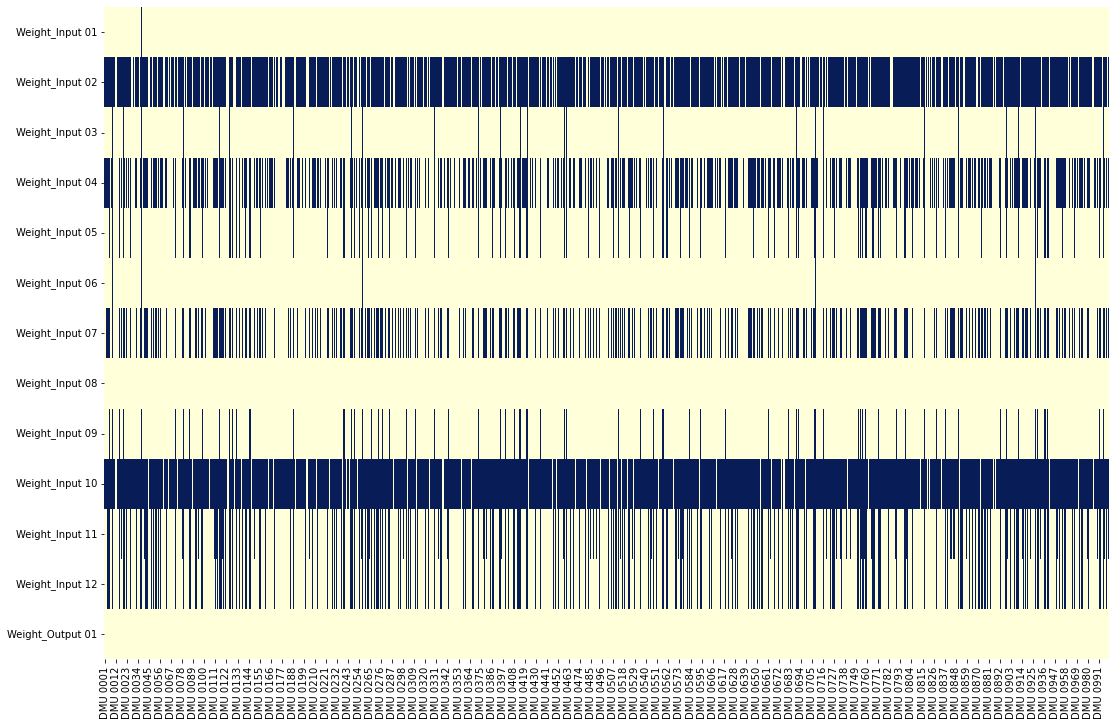

In [67]:
pipe_rf, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_randomforestregressor_Sol_9.xlsx", i=i)
results.append(r)

In [68]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0      Output 01    0.742394  Output 01           0          0
1       Input 08    0.042123   Input 08         428          0
2       Input 09    0.035544   Input 09         599          0
3       Input 01    0.032683   Input 01         330          0
4       Input 03    0.029812   Input 03         249          0
..           ...         ...        ...         ...        ...
125     Input 11    0.005850   Input 11         319          9
126     Input 07    0.005560   Input 07         352          9
127     Input 04    0.005479   Input 04         502          9
128     Input 02    0.005048   Input 02         831          9
129     Input 10    0.005018   Input 10         934          9

[130 rows x 5 columns]

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6530  0.6710 -0.0180     -2.6843            True
1        0.6629  0.6328  0.0301      4.7578           False
2        0.8330  0.8348 -0.0018     -0.2165            True
3        0.8547  0.8347  0.0199      2.3892            True
4        0.7291  0.7839 -0.0548     -6.9940           False
..          ...     ...     ...         ...             ...
195      0.7187  0.7370 -0.0182     -2.4763            True
196      0.8383  0.8267  0.0116      1.4088            True
197      0.7754  0.7893 -0.0139     -1.7651            True
198      0.7779  0.8494 -0.0715     -8.4204           False
199      0.7883  0.8261 -0.0378     -4.5807           False

[200 rows x 5 columns]
blue:  95
red:  105
rho: 0.9483
p-Value 0.0


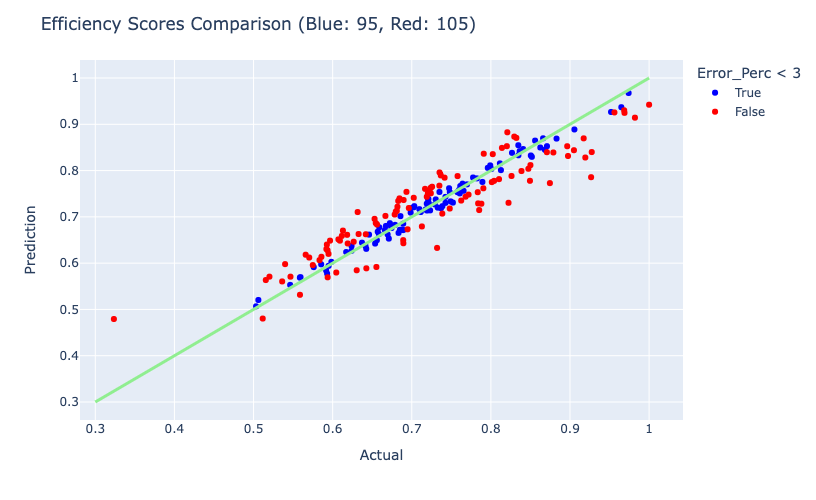

In [69]:
compareML(pipe_rf, y)

blue :  554
red :  446


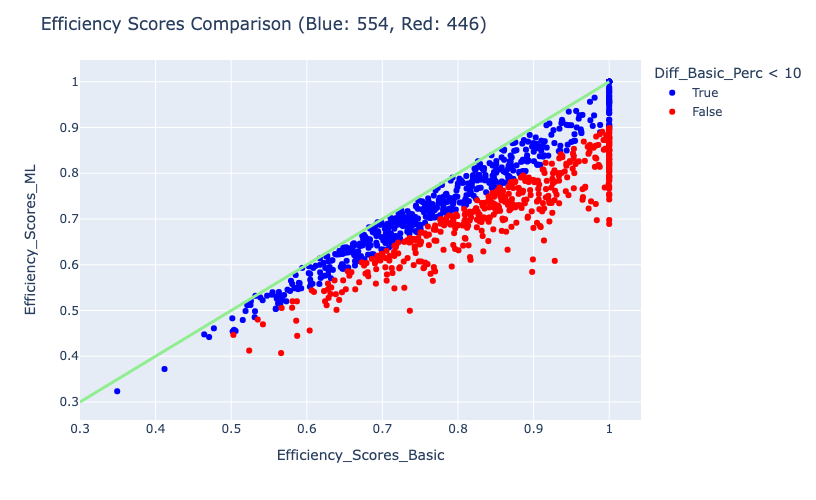

blue :  1000
red :  0


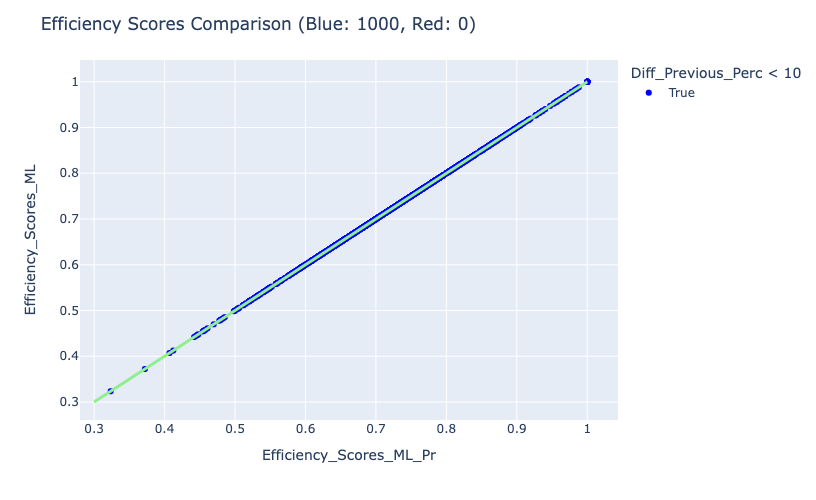

In [70]:
compareES(df_1_path="Data/Data12/US12I1O_randomforestregressor_Sol_9.xlsx", df_0_path="Data/Data12/US12I1O_randomforestregressor_Sol_8.xlsx")

### i = 10

In [71]:
i +=1
i

10

In [72]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

20.0
40.0
60.0
80.0
100.0
Solution file saved


df_zero: 
 Weight_Input 01       1
Weight_Input 02     831
Weight_Input 03      27
Weight_Input 04     502
Weight_Input 05     105
Weight_Input 06       5
Weight_Input 07     352
Weight_Input 08       0
Weight_Input 09      75
Weight_Input 10     934
Weight_Input 11     319
Weight_Input 12     267
Weight_Output 01      0
dtype: int64
Total Zeros:  3418
neg_mean_squared_error: -0.0013299125630562617
neg_root_mean_squared_error: -0.03627860598119156
r2: 0.8944317529336159
grid.best_score:  -0.03633361227340141
grid.best_params:  {'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 100, 'randomforestregressor__bootstrap': True}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=2,
       

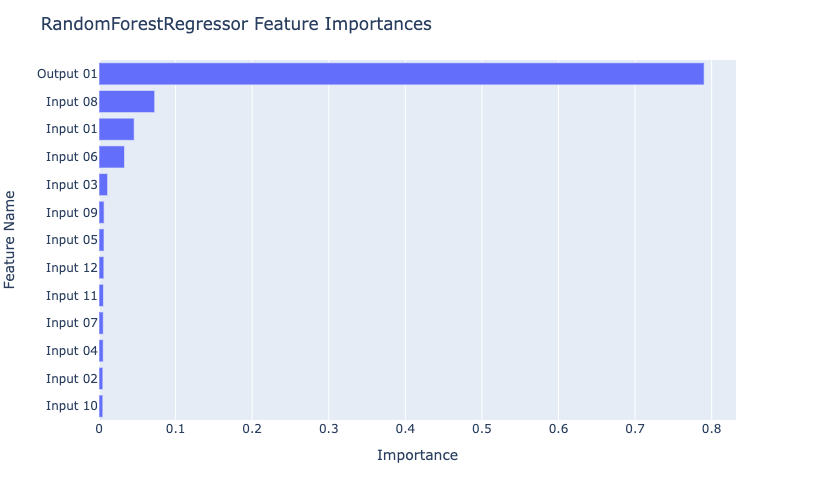

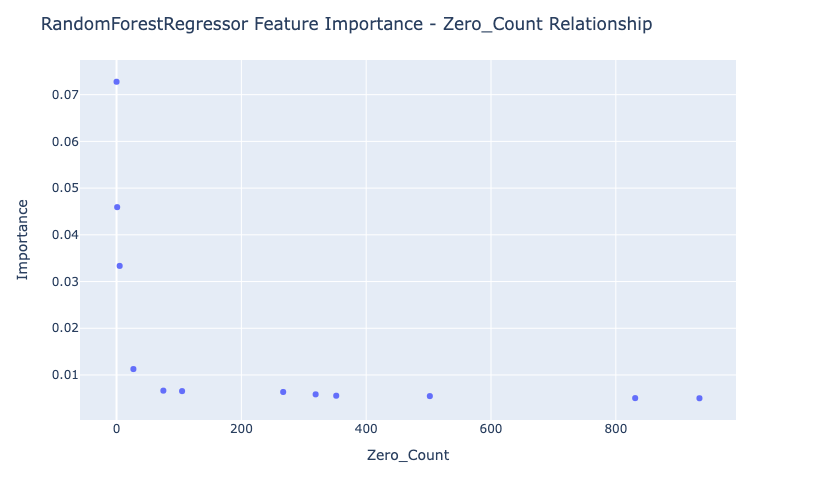

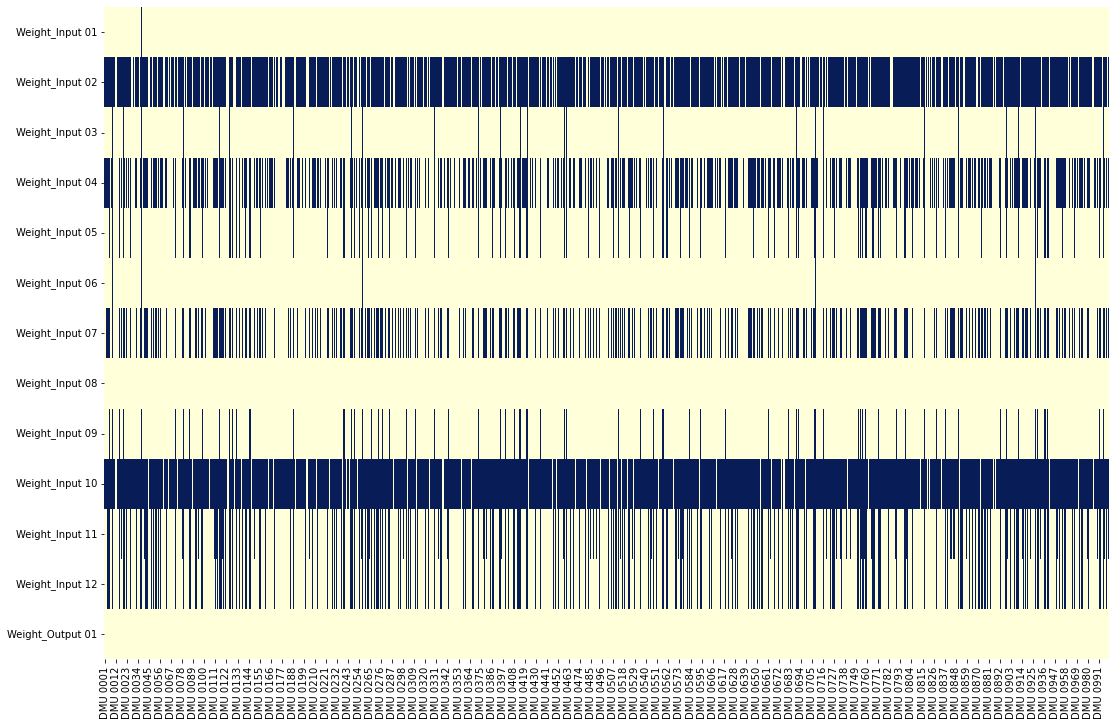

In [73]:
pipe_rf, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_randomforestregressor_Sol_10.xlsx", i=i)
results.append(r)

In [74]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0      Output 01    0.742394  Output 01           0          0
1       Input 08    0.042123   Input 08         428          0
2       Input 09    0.035544   Input 09         599          0
3       Input 01    0.032683   Input 01         330          0
4       Input 03    0.029812   Input 03         249          0
..           ...         ...        ...         ...        ...
138     Input 11    0.005850   Input 11         319         10
139     Input 07    0.005560   Input 07         352         10
140     Input 04    0.005479   Input 04         502         10
141     Input 02    0.005048   Input 02         831         10
142     Input 10    0.005018   Input 10         934         10

[143 rows x 5 columns]

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6530  0.6710 -0.0180     -2.6843            True
1        0.6629  0.6328  0.0301      4.7578           False
2        0.8330  0.8348 -0.0018     -0.2165            True
3        0.8547  0.8347  0.0199      2.3892            True
4        0.7291  0.7839 -0.0548     -6.9940           False
..          ...     ...     ...         ...             ...
195      0.7187  0.7370 -0.0182     -2.4763            True
196      0.8383  0.8267  0.0116      1.4088            True
197      0.7754  0.7893 -0.0139     -1.7651            True
198      0.7779  0.8494 -0.0715     -8.4204           False
199      0.7883  0.8261 -0.0378     -4.5807           False

[200 rows x 5 columns]
blue:  95
red:  105
rho: 0.9483
p-Value 0.0


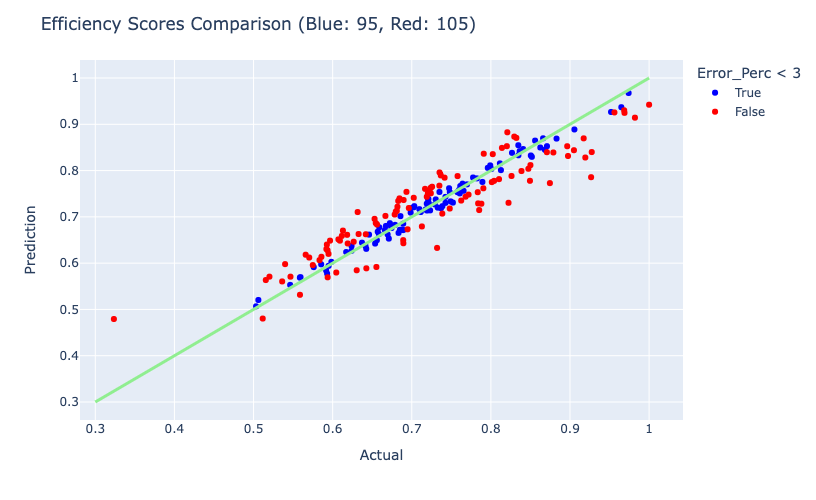

In [75]:
compareML(pipe_rf, y)

blue :  528
red :  472


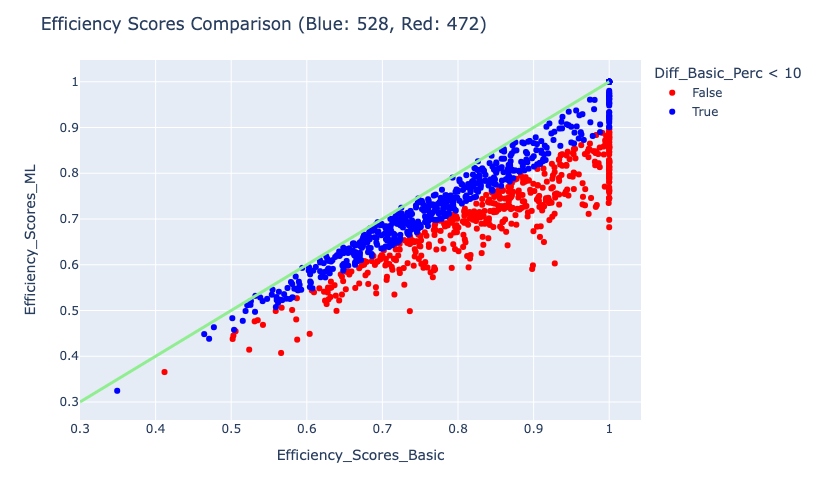

blue :  981
red :  19


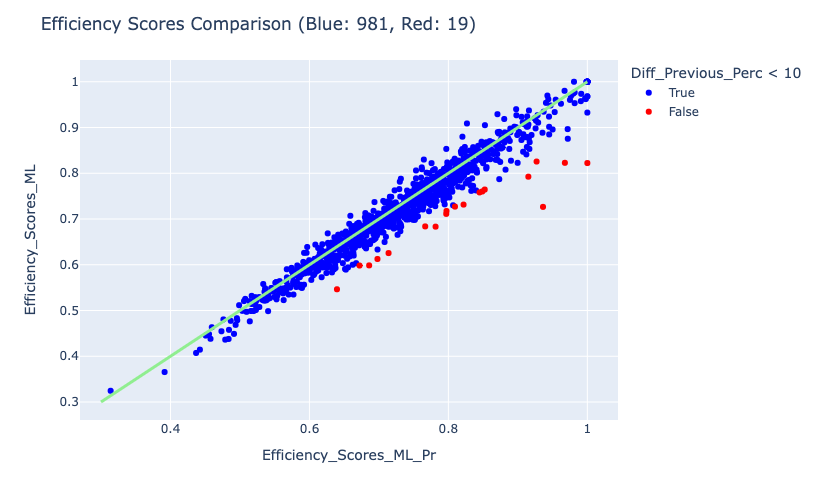

In [76]:
compareES(df_1_path="Data/Data12/US12I1O_randomforestregressor_Sol_2.xlsx", df_0_path="Data/Data12/US12I1O_randomforestregressor_Sol_1.xlsx")

In [77]:
results

[(0,
  'randomforestregressor',
  ['Input 08',
   'Input 09',
   'Input 01',
   'Input 03',
   'Input 06',
   'Input 07',
   'Input 11',
   'Input 04',
   'Input 10',
   'Input 02',
   'Input 05',
   'Input 12'],
  {'r2': 0.8447922999521216,
   'neg_root_mean_squared_error': -0.049480411923112165,
   'total_zeros': 7203}),
 (1,
  'randomforestregressor',
  ['Input 08',
   'Input 01',
   'Input 06',
   'Input 03',
   'Input 12',
   'Input 09',
   'Input 11',
   'Input 10',
   'Input 04',
   'Input 05',
   'Input 07',
   'Input 02'],
  {'r2': 0.877309822156402,
   'neg_root_mean_squared_error': -0.0389974404265591,
   'total_zeros': 4279}),
 (2,
  'randomforestregressor',
  ['Input 08',
   'Input 01',
   'Input 06',
   'Input 03',
   'Input 05',
   'Input 09',
   'Input 12',
   'Input 11',
   'Input 04',
   'Input 02',
   'Input 07',
   'Input 10'],
  {'r2': 0.891913854838603,
   'neg_root_mean_squared_error': -0.03648539188521682,
   'total_zeros': 3008}),
 (3,
  'randomforestregressor'

In [78]:
with open('Data/Data12/RF_result_12I1O.pkl', 'wb') as f:
    pickle.dump(results, f)

In [79]:
with open('Data/Data12/RF_result_12I1O.pkl', 'rb') as f:
    r = pickle.load(f)

In [80]:
r

[(0,
  'randomforestregressor',
  ['Input 08',
   'Input 09',
   'Input 01',
   'Input 03',
   'Input 06',
   'Input 07',
   'Input 11',
   'Input 04',
   'Input 10',
   'Input 02',
   'Input 05',
   'Input 12'],
  {'r2': 0.8447922999521216,
   'neg_root_mean_squared_error': -0.049480411923112165,
   'total_zeros': 7203}),
 (1,
  'randomforestregressor',
  ['Input 08',
   'Input 01',
   'Input 06',
   'Input 03',
   'Input 12',
   'Input 09',
   'Input 11',
   'Input 10',
   'Input 04',
   'Input 05',
   'Input 07',
   'Input 02'],
  {'r2': 0.877309822156402,
   'neg_root_mean_squared_error': -0.0389974404265591,
   'total_zeros': 4279}),
 (2,
  'randomforestregressor',
  ['Input 08',
   'Input 01',
   'Input 06',
   'Input 03',
   'Input 05',
   'Input 09',
   'Input 12',
   'Input 11',
   'Input 04',
   'Input 02',
   'Input 07',
   'Input 10'],
  {'r2': 0.891913854838603,
   'neg_root_mean_squared_error': -0.03648539188521682,
   'total_zeros': 3008}),
 (3,
  'randomforestregressor'

In [81]:
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0      Output 01    0.742394  Output 01           0          0
1       Input 08    0.042123   Input 08         428          0
2       Input 09    0.035544   Input 09         599          0
3       Input 01    0.032683   Input 01         330          0
4       Input 03    0.029812   Input 03         249          0
..           ...         ...        ...         ...        ...
138     Input 11    0.005850   Input 11         319         10
139     Input 07    0.005560   Input 07         352         10
140     Input 04    0.005479   Input 04         502         10
141     Input 02    0.005048   Input 02         831         10
142     Input 10    0.005018   Input 10         934         10

[143 rows x 5 columns]

In [82]:
df_imp.Iteration.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [83]:
df_imp.to_pickle('Data/Data12/RF_12I1O_df_imp.pkl')